In [1]:
#'/home/wangb/实习生/2024财务因子整理'

In [1010]:
import numpy as np
import pandas as pd
from cylib.apis.all_api import *
from cylib.qmtdata.cyxtdata import xtdata
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm  #ols线性回归
import sys
import seaborn as sns
# 将指定路径添加到模块搜索路径中
sys.path.append('/home/wangb/晨乐多因子/因子储备')
# 导入stock_test模块
import stock_test as stk_tst

## TTM

In [966]:
# 获取沪深300指数成分
hs300_list = list(xtdata.get_index_weight('000300.SH').keys())


# xtdata.download_financial_data(hs300_list, table_list=["Balance","Income"])            # 下载数据

# 获取财务报表）
financial_data = xtdata.get_financial_data(hs300_list,["Balance","Income"])
#print(financial_data)
# 以营业利润为例 （oper_profit）
All_data = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['Income'][['m_timetag','m_anntime','oper_profit']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_timetag','m_anntime','oper_profit']]
    temp = temp[temp.m_anntime>='20150101']
    All_data = All_data.append(temp)
    
All_data['Year'] = All_data['m_timetag'].apply(lambda x:x[:4])
All_data['Month'] = All_data['m_timetag'].apply(lambda x:x[4:6])
All_data.head(5)

,ts_code,m_timetag,m_anntime,oper_profit,Year,Month
71,000001.SZ,20141231,20150313,2.624600e+10,2014,12
72,000001.SZ,20150331,20150424,7.447000e+09,2015,03
73,000001.SZ,20150630,20150814,1.526700e+10,2015,06
74,000001.SZ,20150930,20151023,2.330500e+10,2015,09
75,000001.SZ,20151231,20160310,2.889500e+10,2015,12


In [1003]:
def cal_factor_dif(data,factor):    
    def cal_group_dif(group,factor):
        res = group[factor].diff()
        res = res.fillna(group[factor])
        return res
    data[f'{factor}_diff'] = data.groupby('Year').apply(lambda x:cal_group_dif(x,factor)).reset_index(level=0, drop=True)
    return data

In [987]:
def cal_factor_ttm(data,factor):
    """
    计算factor_ttm.
    factor_diff ：单季度factor数值
    factor_ttm ：滚动四个季度factor之和
    """
    
    def cal_group_dif(group,factor):
        res = group[factor].diff()
        res = res.fillna(group[factor])
        return res
    data[f'{factor}_diff'] = data.groupby('Year').apply(lambda x:cal_group_dif(x,factor)).reset_index(level=0, drop=True)
    data[f'{factor}_TTM'] = data[f'{factor}_diff'].rolling(4).sum()
    return data

All_data = All_data.groupby('ts_code').apply(lambda x:cal_factor_ttm(x,'oper_profit'))
All_data['m_timetag'] = pd.to_datetime(All_data['m_timetag'])
All_data['m_anntime'] = pd.to_datetime(All_data['m_anntime'])
pd.set_option('display.max_rows', 5)
All_data

,ts_code,m_timetag,m_anntime,oper_profit,Year,Month,oper_profit_diff,oper_profit_TTM
71,000001.SZ,2014-12-31,2015-03-13,2.624600e+10,2014,12,2.624600e+10,NaN
72,000001.SZ,2015-03-31,2015-04-24,7.447000e+09,2015,03,7.447000e+09,NaN
...,...,...,...,...,...,...,...,...
21,688981.SH,2023-12-31,2024-03-29,6.905885e+09,2023,12,1.740422e+09,6.905885e+09
22,688981.SH,2024-03-31,2024-05-10,5.281070e+08,2024,03,5.281070e+08,5.537094e+09


## 1025成交额
$$mean(最近K个月成交额序列)$$
衡量股票交易流动性的重要指标，如果股票流动性较差，价格相对较低，投资者对其预期收益率就会较高

In [680]:
#每日成交额
stdata = xtdata.get_market_data_ex(
    field_list=['open','high','low','close','amount','volume'], stock_list=hs300_list, period='1d',
    start_time='20180101', end_time='', count=-1,
    dividend_type='front', fill_data=True
)

data = pd.DataFrame()
for i in stdata.keys():
    temp = stdata[i]
    temp['ts_code'] = i
    data = data.append(temp)
data = data.reset_index()
data = data.rename(columns = {'index':'trade_date'})
data.set_index('trade_date', inplace = True)
data.index = pd.to_datetime(data.index)
data = data[data.amount !=0]
stocks = list(stdata.keys())
dates = list(stdata[stocks[0]].index)
data_array = np.zeros((len(dates), len(stocks)))
for i, stock in enumerate(stocks):
    data_array[:, i] = stdata[stock]['amount'].values
df_st = pd.DataFrame(data_array, index=[str(date) for date in dates], columns=stocks)

In [681]:
mean_amount = data.copy()
mean_amount['mean_amount'] = data.groupby('ts_code')['amount'].transform(lambda x:x.rolling(252).mean())
mean_amount = mean_amount.dropna()
mean_amount

,open,high,low,close,volume,amount,ts_code,mean_amount
trade_date,,,,,,,,
2019-01-14,8.445,8.475,8.295,8.335,500443,5.078629e+08,000001.SZ,1.263170e+09
2019-01-15,8.335,8.505,8.315,8.465,542160,5.530273e+08,000001.SZ,1.254029e+09
...,...,...,...,...,...,...,...,...
2024-08-05,47.950,48.480,47.000,47.290,233085,1.111376e+09,688981.SH,1.273481e+09
2024-08-06,47.700,47.960,46.300,47.270,177103,8.329252e+08,688981.SH,1.274567e+09


<Axes: xlabel='mean_amount', ylabel='Count'>

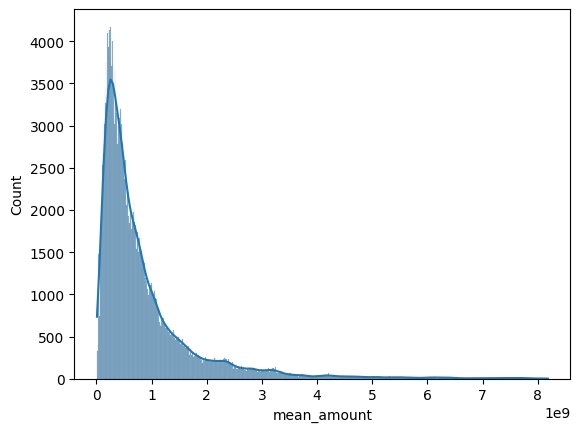

In [690]:
sns.histplot(mean_amount['mean_amount'], bins=1000, kde=True)

In [16]:
#stk_tst.factor_test(mean_amount,5,'2021-01-01','mean_amount')

## 1022十大股东占比分散度
$$std(十大股东各自持仓占比序列)$$
刻画了股票十大股东各自持仓的不均衡程度，属于正向因子。十大股东持股越不均衡，股票越集中在前几位大股东手中，该股票后续走势相对会更好。

In [956]:
#获得十大股东持仓占比序列
financial_data = xtdata.get_financial_data(hs300_list,["TOP10FLOWHOLDER"])
All_data1022 = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['TOP10FLOWHOLDER'][['declareDate','endDate','ratio']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','declareDate','endDate','ratio']]
    temp = temp[temp.declareDate>='20180101']
    All_data1022 = All_data1022.append(temp)

In [957]:
financial_data['000001.SZ']['TOP10FLOWHOLDER'].iloc[:10]['ratio'].std()

0.11589267065311384

In [958]:
(All_data1022[All_data1022.ts_code == '000001.SZ'].iloc[10:20]['ratio']*0.01).std()

0.1473800601053842

In [959]:
def TOP10(All_data1022):
    std_devs = All_data1022.groupby(['ts_code', 'declareDate'])['ratio'].std().reset_index()
    std_devs.columns = ['ts_code', 'declareDate', 'ratio_std']
    std_devs = std_devs.reset_index(drop=True)
    return std_devs
TOP10stocks = TOP10(All_data1022)
TOP10stocks

,ts_code,declareDate,ratio_std
0,000001.SZ,20180315,14.720635
1,000001.SZ,20180420,14.738006
...,...,...,...
7054,688981.SH,20240329,16.408433
7055,688981.SH,20240510,16.415049


<Axes: xlabel='ratio_std', ylabel='Count'>

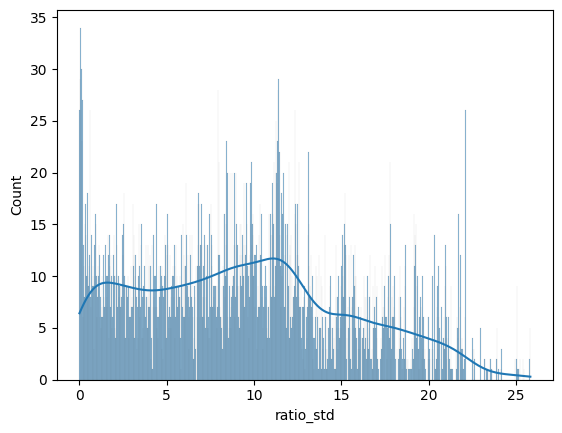

In [697]:
sns.histplot(TOP10stocks['ratio_std'], bins=1000, kde=True)

# 1019存货增长率
$$\frac{最近报告期存货 - 上年同期}{上年同期}$$
存货同比增速，低存货增长的公司表现优于高存货增长的公司。

In [1084]:
#存货
#xtdata.download_financial_data(hs300_list, table_list=["TOP10FLOWHOLDER"])
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREBALANCESHEET"])
All_data1019 = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREBALANCESHEET'][['m_anntime','m_timetag','inventories']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','inventories']]
    temp = temp[temp.m_timetag>='20180101']
    All_data1019 = All_data1019.append(temp)
    All_data1019 = All_data1019.dropna()#去除了空值的股票
All_data1019

,ts_code,m_anntime,m_timetag,inventories
82,000002.SZ,20180426,20180331,6.300930e+11
83,000002.SZ,20180821,20180630,6.386235e+11
...,...,...,...,...
18,688981.SH,20240329,20231231,1.937771e+10
19,688981.SH,20240510,20240331,1.964021e+10


In [1088]:
#去年
merged_data['inventory_growth_rate'] = (
    (merged_data['inventories'] - merged_data['inventories'].shift(4)) / merged_data['inventories'].shift(4)
)
merged_data

,ts_code,m_anntime,m_timetag,inventories,m_timetag_last_year,inventories_last_year,m_timetag_oneyear,inventory_growth_rate
0,000002.SZ,20180426,20180331,6.300930e+11,2018-03-31,4.916367e+11,2017-03-31,NaN
1,000002.SZ,20180821,20180630,6.386235e+11,2018-06-30,4.962991e+11,2017-06-30,NaN
...,...,...,...,...,...,...,...,...
7421,688981.SH,20240329,20231231,1.937771e+10,2023-12-31,1.331275e+10,2022-12-31,0.455575
7422,688981.SH,20240510,20240331,1.964021e+10,2024-03-31,1.457333e+10,2023-03-31,0.347681


In [1089]:
All_data1019_last[(All_data1019_last.ts_code == '300442.SZ')&(All_data1019_last.m_anntime<='20240427')]

,ts_code,m_anntime,m_timetag,inventories,m_timetag_oneyear
13,300442.SZ,20170419,2017-03-31,NaN,2016-03-31
14,300442.SZ,20170825,2017-06-30,NaN,2016-06-30
...,...,...,...,...,...
40,300442.SZ,20240418,2023-12-31,1533233.13,2022-12-31
41,300442.SZ,20240427,2024-03-31,1299079.31,2023-03-31


In [1090]:
#merged_data = merged_data.drop_duplicates(subset=['ts_code', 'm_timetag'])
merged_data[(merged_data.ts_code == '300442.SZ')&(merged_data.m_anntime<='20240427')]

,ts_code,m_anntime,m_timetag,inventories,m_timetag_last_year,inventories_last_year,m_timetag_oneyear,inventory_growth_rate
2575,300442.SZ,20180424,20180331,4.265387e+08,2017-12-31,NaN,2016-12-31,-0.940918
2576,300442.SZ,20180424,20180331,4.265387e+08,2018-03-31,3.569021e+08,2017-03-31,-0.950212
...,...,...,...,...,...,...,...,...
2603,300442.SZ,20240418,20231231,7.696474e+08,2023-12-31,1.533233e+06,2022-12-31,591.456024
2604,300442.SZ,20240427,20240331,2.408939e+09,2024-03-31,1.299079e+06,2023-03-31,1853.343655


<Axes: xlabel='inventory_growth_rate', ylabel='Count'>

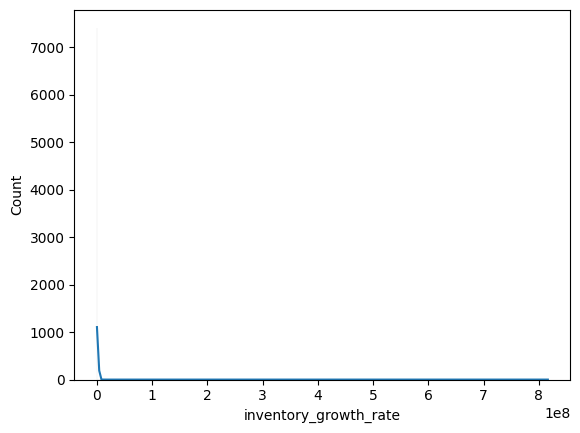

In [1091]:
sns.histplot(merged_data['inventory_growth_rate'], bins=1000, kde=True)

In [1092]:
#存文件
merged_data.to_csv('temp.csv', index=False)

<Axes: xlabel='inventory_growth_rate', ylabel='Count'>

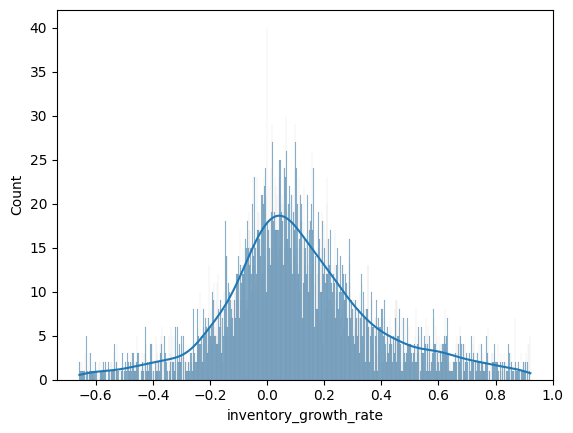

In [1093]:
#数据处理
# Calculate the first (Q1) and third (Q3) quartiles, and the interquartile range (IQR)
Q1 = merged_data['inventory_growth_rate'].quantile(0.25)
Q3 = merged_data['inventory_growth_rate'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier cutoff values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_df = merged_data[(merged_data['inventory_growth_rate'] >= lower_bound) & (merged_data['inventory_growth_rate'] <= upper_bound)]
sns.histplot(filtered_df['inventory_growth_rate'], bins=1000, kde=True)

## 1010未预期税费支出
$$\frac{最近单季度所得税费用 - 上年同期单季度所得税费用}{上年同期单季度所得税费用}$$
税收支出的季节性差异与未来收益呈正相关，税收支出包含有关核心盈利能力的信息，反映到股价上

In [1017]:
#所得税
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREINCOME"])
All_data1010 = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREINCOME'][['m_anntime','m_timetag','inc_tax']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','inc_tax']]
    temp = temp[temp.m_timetag>='20180101']
    All_data1010 = All_data1010.append(temp)
    #All_data1010 = All_data1010.dropna()#去除了空值的股票
    #All_data1010['inc_tax_diff'] = All_data1010.groupby('ts_code')['inc_tax'].diff()
All_data1010['Year'] = All_data1010['m_timetag'].apply(lambda x:x[:4])
All_data1010 = All_data1010.groupby('ts_code').apply(lambda x:cal_factor_dif(x,'inc_tax'))
All_data1010

,ts_code,m_anntime,m_timetag,inc_tax,Year,inc_tax_diff
84,000001.SZ,20180420,20180331,1.972000e+09,2018,1.972000e+09
85,000001.SZ,20180816,20180630,3.995000e+09,2018,2.023000e+09
...,...,...,...,...,...,...
21,688981.SH,20240329,20231231,4.442660e+08,2023,7.599000e+07
22,688981.SH,20240510,20240331,7.739200e+07,2024,7.739200e+07


In [1006]:
All_data1010['ans'] = All_data1010.groupby('ts_code')['inc_tax_diff'].apply(lambda x: (x - x.shift(4)) / x.shift(4))
All_data1010[All_data1010.ts_code == '000001.SZ']

,ts_code,m_anntime,m_timetag,inc_tax,Year,inc_tax_diff,ans
84,000001.SZ,20180420,20180331,1.972000e+09,2018,1.972000e+09,NaN
85,000001.SZ,20180816,20180630,3.995000e+09,2018,2.023000e+09,NaN
...,...,...,...,...,...,...,...
107,000001.SZ,20240315,20231231,1.126300e+10,2023,1.905000e+09,-0.165937
108,000001.SZ,20240420,20240331,3.593000e+09,2024,3.593000e+09,-0.045684


<Axes: xlabel='ans', ylabel='Count'>

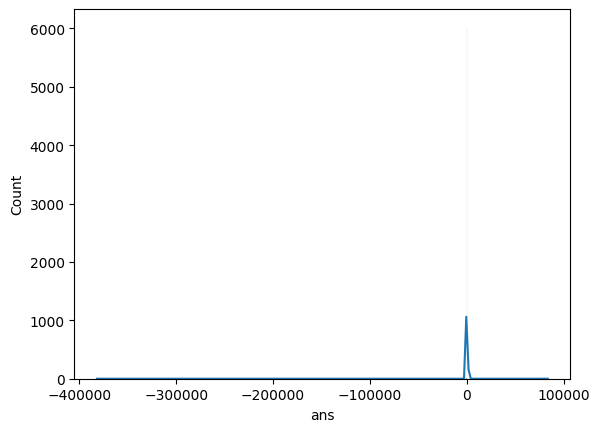

In [1008]:
sns.histplot(All_data1010['ans'], bins=1000, kde=True)

<Axes: xlabel='ans', ylabel='Count'>

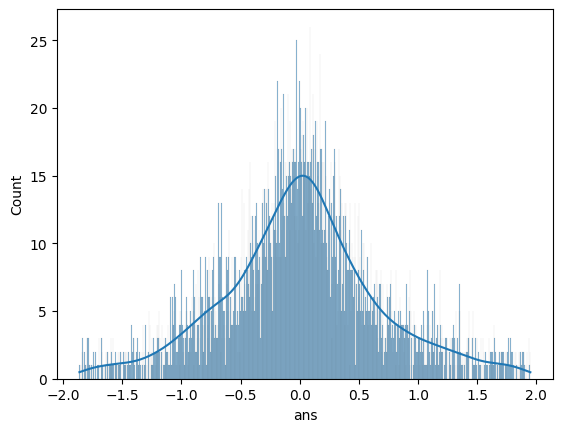

In [1014]:
#数据处理
# Calculate the first (Q1) and third (Q3) quartiles, and the interquartile range (IQR)
Q1 = All_data1010['ans'].quantile(0.25)
Q3 = All_data1010['ans'].quantile(0.75)
IQR = Q3 - Q1
# Define the outlier cutoff values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter out the outliers
filtered_df = All_data1010[(All_data1010['ans'] >= lower_bound) & (All_data1010['ans'] <= upper_bound)]
sns.histplot(filtered_df['ans'], bins=1000, kde=True)

## 1001单季度总资产净利率变动
$$最近报告期单季度总资产净利率 - 上年同期单季度总资产净利率$$

即单季度总资产净利率的同比增量
成长因子是基于股票过去一段时间的各项估值或盈利指标计算得到的增长量或增长率指标，用于衡量公司各个维度的成长性  
计算成长因子时，最常用的统计维度有:环比增长率，同比增长率  
至于增长率和增长量，表现差异不大，整张率更具有可比性，增量更不容易收到基础指标取值异常的影响  

In [1094]:
#净利率
financial_data = xtdata.get_financial_data(hs300_list,["PERSHAREINDEX"])
All_data1001 = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['PERSHAREINDEX'][['m_anntime','m_timetag','net_profit']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','net_profit']]
    temp = temp[temp.m_timetag>='20230101']
    All_data1001 = All_data1001.append(temp)
    #All_data1001 = All_data1001.dropna()#去除了空值的股票
#All_data1001

In [1096]:
#去年
All_data1001['change'] = (
    (All_data1001['net_profit'] - All_data1001['net_profit'].shift(4)) 
)
All_data1001

,ts_code,m_anntime,m_timetag,net_profit,change
84,000001.SZ,20230425,20230331,32.3784,NaN
85,000001.SZ,20230824,20230630,28.6503,NaN
...,...,...,...,...,...
33,688981.SH,20240329,20231231,14.1350,11.3821
34,688981.SH,20240510,20240331,3.5745,-14.4380


<Axes: xlabel='change', ylabel='Count'>

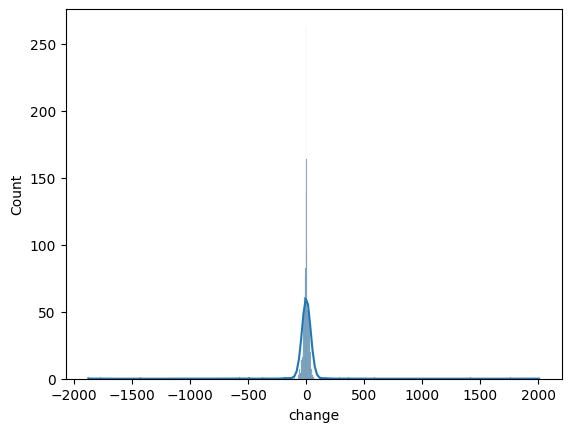

In [1098]:
sns.histplot(All_data1001['change'], bins=1000, kde=True)

<Axes: xlabel='change', ylabel='Count'>

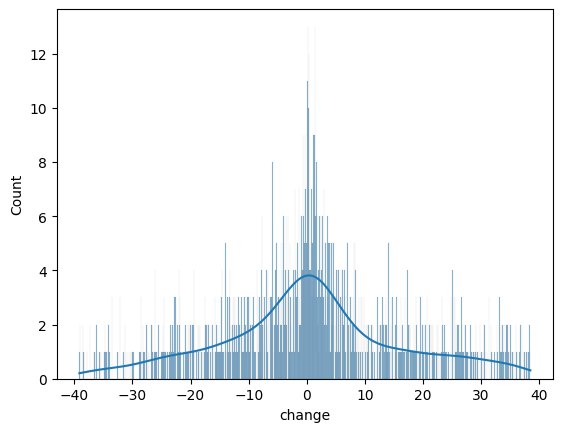

In [1097]:
#数据处理
# Calculate the first (Q1) and third (Q3) quartiles, and the interquartile range (IQR)
Q1 = All_data1001['change'].quantile(0.25)
Q3 = All_data1001['change'].quantile(0.75)
IQR = Q3 - Q1
# Define the outlier cutoff values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter out the outliers
filtered_df = All_data1001[(All_data1001['change'] >= lower_bound) & (All_data1001['change'] <= upper_bound)]
sns.histplot(filtered_df['change'], bins=1000, kde=True)

In [ ]:
#存文件
All_data1001.to_csv('temp.csv', index=False)

## 0929盈利市值比（去杠杆）
$$\frac{最近12个月的毛利润(TTM)}{当日经营性净资产市值} $$
其中  
$$经营性净资产市值=金融负债-金融资产+市值$$
说明  
改进后的市盈率倒数，不受企业杠杆的影响，对企业估值更合理准确，选股能力显著提高;计算时将“市值”替换成了“经营性净资产市值”，对债权和股权都做了市场定价，而且剥离了企业金融性活动的影响，能更准确反映企业核心资产;将“净利润”替换成“毛利润”，剔除了容易操纵的销售管理等费用的影响。

In [ ]:
#同上无毛利率数据，逻辑类似0731，0822

## 0926市场杠杆
$$\frac{最近报告期的总资产}{总市值}$$
表示资产总额是总市值的多少倍，平均回报率与市场杠杆正相关    

In [1188]:
#总资产
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREBALANCESHEET"])
All_data = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREBALANCESHEET'][['m_anntime','m_timetag','tot_assets']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','tot_assets']]
    temp = temp[temp.m_timetag>='20180101']
    All_data = All_data.append(temp)
    #All_data = All_data.dropna()#去除了空值的股票
# All_data = All_data.groupby('ts_code').apply(lambda x: x.tail(1)) 

In [1137]:
#总市值
stock_price = get_price(ts_code_list = hs300_list,feature_list = ['total_mv'],
start_date='20180101',trade_date = '20240801',back_len = 1,target_type='stock')
stock_price = stock_price.sort_index(ascending=True)
#stock_price

In [1173]:
stock_price = stock_price.reset_index(level='trade_date')
stock_price

,trade_date,total_mv
ts_code,,
000001.SZ,2018-01-02,23523500.0
000002.SZ,2018-01-02,35943500.0
000063.SZ,2018-01-02,14980400.0
000100.SZ,2018-01-02,5284350.0
000157.SZ,2018-01-02,3546290.0
...,...,...
688303.SH,2024-08-01,4242690.0
688363.SH,2024-08-01,2957020.0
688396.SH,2024-08-01,5312600.0


In [1189]:
All_data['m_anntime'] = pd.to_datetime(All_data['m_anntime'])

In [1192]:
merged_df = pd.merge(stock_price, All_data, how='outer', left_on=['ts_code', 'trade_date'], right_on=['ts_code', 'm_anntime'])
merged_df['tot_assets'] = merged_df.groupby('ts_code')['tot_assets'].apply(lambda x: x.ffill())
merged_df['Market_leverage'] = merged_df['tot_assets'] / merged_df['total_mv']

In [1194]:
#pd.set_option('display.max_rows',None) #None
pd.reset_option('display.max_rows')

In [1193]:
merged_df[merged_df.ts_code == '000001.SZ']

,ts_code,trade_date,total_mv,m_anntime,m_timetag,tot_assets,Market_leverage
0,000001.SZ,2018-01-02,23523500.0,NaT,NaN,NaN,NaN
236,000001.SZ,2018-01-03,22888200.0,NaT,NaN,NaN,NaN
472,000001.SZ,2018-01-04,22750800.0,NaT,NaN,NaN,NaN
709,000001.SZ,2018-01-05,22836600.0,NaT,NaN,NaN,NaN
946,000001.SZ,2018-01-08,22252900.0,NaT,NaN,NaN,NaN
1184,000001.SZ,2018-01-09,22458900.0,NaT,NaN,NaN,NaN
1422,000001.SZ,2018-01-10,23128500.0,NaT,NaN,NaN,NaN
1660,000001.SZ,2018-01-11,23008400.0,NaT,NaN,NaN,NaN
1898,000001.SZ,2018-01-12,23265900.0,NaT,NaN,NaN,NaN
2136,000001.SZ,2018-01-15,24382000.0,NaT,NaN,NaN,NaN


<Axes: xlabel='Market_leverage', ylabel='Count'>

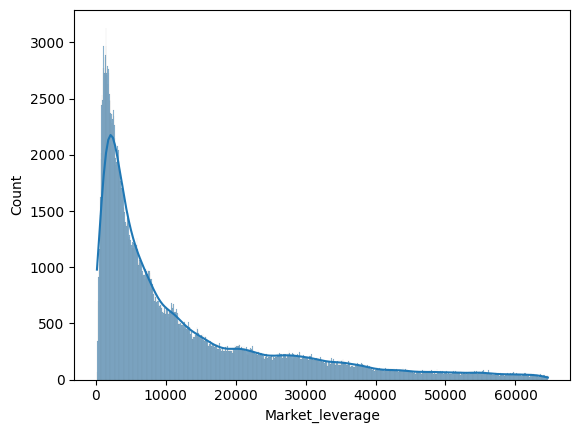

In [1195]:
#数据处理
# Calculate the first (Q1) and third (Q3) quartiles, and the interquartile range (IQR)
Q1 = merged_df['Market_leverage'].quantile(0.25)
Q3 = merged_df['Market_leverage'].quantile(0.75)
IQR = Q3 - Q1
# Define the outlier cutoff values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter out the outliers
filtered_df = merged_df[(merged_df['Market_leverage'] >= lower_bound) & (merged_df['Market_leverage'] <= upper_bound)]
sns.histplot(filtered_df['Market_leverage'], bins=1000, kde=True)

## 0922基于振幅切割的动量
$$振幅因子=\frac{(t日最高价 - t日最低价)}{(t-1日收盘价)}$$
以160个交易日作为窗口期，将振幅较低的入%个交易日的涨跌幅加总，得到动量因子，入%取值范围在[50%,70%]。  
说明  
作者从交易行为维度出发，利用日度振幅，从长端涨跌幅中切割出了有效的动量因子;而且测试发现低振幅水平下涨跌幅因子呈现动量效应，高振幅水平下涨跌幅因子呈现反转效应，并且动量效应和反转效应的分布和强度具有不对称性。  

In [756]:
#t日最高价
stdata = xtdata.get_market_data_ex(
    field_list=['high'], stock_list=hs300_list, period='1d',
    start_time='20180101', end_time='', count=-1,
    dividend_type='front_ratio', fill_data=True
)
stocks = list(stdata.keys())
dates = list(stdata[stocks[0]].index)
data_array = np.zeros((len(dates), len(stocks)))
for i, stock in enumerate(stocks):
    data_array[:, i] = stdata[stock]['high'].values
df_upst = pd.DataFrame(data_array, index=[str(date) for date in dates], columns=stocks)

In [757]:
#t日最低价
stdata = xtdata.get_market_data_ex(
    field_list=['low'], stock_list=hs300_list, period='1d',
    start_time='20180101', end_time='', count=-1,
    dividend_type='front_ratio', fill_data=True
)
stocks = list(stdata.keys())
dates = list(stdata[stocks[0]].index)
data_array = np.zeros((len(dates), len(stocks)))
for i, stock in enumerate(stocks):
    data_array[:, i] = stdata[stock]['low'].values
df_downst = pd.DataFrame(data_array, index=[str(date) for date in dates], columns=stocks)

In [758]:
#t-1日收盘价
stdata = xtdata.get_market_data_ex(
    field_list=['preClose'], stock_list=hs300_list, period='1d',
    start_time='20180101', end_time='', count=-1,
    dividend_type='front_ratio', fill_data=True
)
stocks = list(stdata.keys())
dates = list(stdata[stocks[0]].index)
data_array = np.zeros((len(dates), len(stocks)))
for i, stock in enumerate(stocks):
    data_array[:, i] = stdata[stock]['preClose'].values
df_pClst = pd.DataFrame(data_array, index=[str(date) for date in dates], columns=stocks)

In [759]:
#振幅
ans = (df_upst - df_downst)/(df_pClst)

In [760]:
#因子
result = ans.rolling(160).apply(lambda x: np.sort(x)[:len(x) // 2].sum(), raw=True)

In [761]:
result['000001.SZ']

20180102         NaN
20180103         NaN
              ...   
20240805    1.022785
20240806    1.027988
Name: 000001.SZ, Length: 1601, dtype: float64

In [762]:
result

,000001.SZ,000002.SZ,000063.SZ,000100.SZ,000157.SZ,000166.SZ,000301.SZ,000333.SZ,000338.SZ,000408.SZ,...,688126.SH,688187.SH,688223.SH,688256.SH,688271.SH,688303.SH,688363.SH,688396.SH,688599.SH,688981.SH
20180102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20240805,1.022785,1.747287,1.583112,1.689621,1.564595,1.092562,1.454264,1.444904,1.641534,1.698091,...,1.726890,2.018672,1.900888,3.498327,1.579019,1.711697,1.62882,1.607456,2.073426,1.543616
20240806,1.027988,1.750978,1.581522,1.699048,1.564186,1.092562,1.454264,1.444904,1.641372,1.684096,...,1.732577,2.012248,1.900695,3.499554,1.579019,1.713389,1.62882,1.605521,2.079390,1.547903


<Axes: ylabel='Count'>

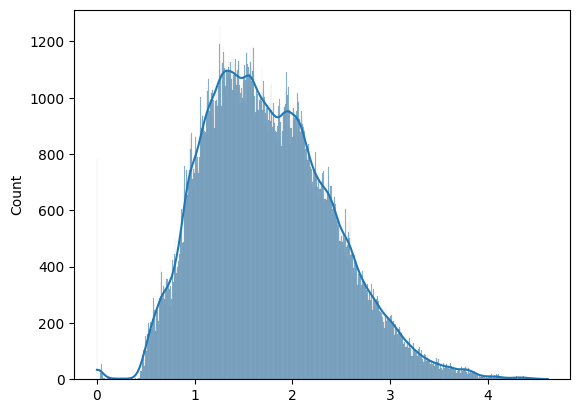

In [765]:
all_values = result.select_dtypes(include=[int, float]).values.flatten()
sns.histplot(all_values, bins=1000, kde=True)

## 0902单季度总资产报酬率变动
$$总资产报酬率=\frac{（ 利润总额 + 利息支出 ）}{平均总资产}$$
$$最近报告期单季度总资产报酬率-上年同期单季度总资产报酬率$$
即单季度总资产报酬率的同比增量  
① 成长因子是基于股票过去一段时间的各项估值或盈利指标计算得到的增长量或增长率指标，用于衡量公司各个维度的成长性;  
② 计算成长因子时，最常用的统计维度有:环比增长率(或环比增量)、同比增长率(或同比增量)，计算用的基础财务数据也有“最近12个月TTM”和“单季度”2类，经测试发现:“单季度同比”和“TTM环比”这2个维度下计算得到的因子表现通常相对更优;  
③ 至于增长率和增量，表现相差不大，增长率更具可比性，增量更不容易受基础指标取值异常的影响。  

In [1018]:
#利润总额，利息支出
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREINCOME"])
All_data = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREINCOME'][['m_anntime','m_timetag','tot_profit','less_int_exp']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','tot_profit','less_int_exp']]
    temp = temp[temp.m_timetag>='20180101']
    All_data = All_data.append(temp)
    All_data.fillna(0, inplace=True)
All_data['Year'] = All_data['m_timetag'].apply(lambda x:x[:4])
All_data = All_data.groupby('ts_code').apply(lambda x:cal_factor_dif(x,'tot_profit'))
All_data = All_data.groupby('ts_code').apply(lambda x:cal_factor_dif(x,'less_int_exp'))

In [1019]:
All_data

,ts_code,m_anntime,m_timetag,tot_profit,less_int_exp,Year,tot_profit_diff,less_int_exp_diff
84,000001.SZ,20180420,20180331,8.567000e+09,0.0,2018,8.567000e+09,0.0
85,000001.SZ,20180816,20180630,1.736700e+10,0.0,2018,8.800000e+09,0.0
...,...,...,...,...,...,...,...,...
21,688981.SH,20240329,20231231,6.840418e+09,0.0,2023,1.670889e+09,0.0
22,688981.SH,20240510,20240331,5.275520e+08,0.0,2024,5.275520e+08,0.0


In [1023]:
#总资产
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREBALANCESHEET"])
All_data1 = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREBALANCESHEET'][['m_anntime','m_timetag','tot_assets']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','tot_assets']]
    temp = temp[temp.m_timetag>='20180101']
    All_data1 = All_data1.append(temp)
    #All_data = All_data.dropna()#去除了空值的股票

In [1024]:
#平均总资产（1年）
All_data1['Avg'] = All_data1.groupby('ts_code')['tot_assets'].apply(lambda x: (x + x.shift(4)) / 2)

In [1037]:
#内连接
merged_df = pd.merge(All_data, All_data1, how='inner', left_on=['ts_code', 'm_anntime','m_timetag'], right_on=['ts_code', 'm_anntime','m_timetag'])
#总资产报酬率
merged_df['Return_on_total_assets'] = (merged_df['less_int_exp_diff'] + merged_df['tot_profit_diff'])/merged_df['Avg']

In [1038]:
#去年
merged_df['Return_on_total_assets_change'] = merged_df['Return_on_total_assets'] - merged_df['Return_on_total_assets'].shift(4)

In [1039]:
#!!!由于利息支出权威NaN所以无结果

In [1040]:
merged_df[merged_df.ts_code == '000001.SZ']

,ts_code,m_anntime,m_timetag,tot_profit,less_int_exp,Year,tot_profit_diff,less_int_exp_diff,tot_assets,Avg,Return_on_total_assets,Return_on_total_assets_change
0,000001.SZ,20180420,20180331,8.567000e+09,0.0,2018,8.567000e+09,0.0,3.338572e+12,NaN,NaN,NaN
1,000001.SZ,20180816,20180630,1.736700e+10,0.0,2018,8.800000e+09,0.0,3.367399e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
22,000001.SZ,20240315,20231231,5.771800e+10,0.0,2023,8.725000e+09,0.0,5.587116e+12,5.454315e+12,0.001600,-0.000576
23,000001.SZ,20240420,20240331,1.852500e+10,0.0,2024,1.852500e+10,0.0,5.729398e+12,5.592648e+12,0.003312,-0.000162


In [1041]:
merged_df

,ts_code,m_anntime,m_timetag,tot_profit,less_int_exp,Year,tot_profit_diff,less_int_exp_diff,tot_assets,Avg,Return_on_total_assets,Return_on_total_assets_change
0,000001.SZ,20180420,20180331,8.567000e+09,0.0,2018,8.567000e+09,0.0,3.338572e+12,NaN,NaN,NaN
1,000001.SZ,20180816,20180630,1.736700e+10,0.0,2018,8.800000e+09,0.0,3.367399e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6448,688981.SH,20240329,20231231,6.840418e+09,0.0,2023,1.670889e+09,0.0,3.384632e+11,3.217834e+11,0.005193,-0.005962
6449,688981.SH,20240510,20240331,5.275520e+08,0.0,2024,5.275520e+08,0.0,3.417577e+11,3.259265e+11,0.001619,-0.005312


<Axes: xlabel='Return_on_total_assets_change', ylabel='Count'>

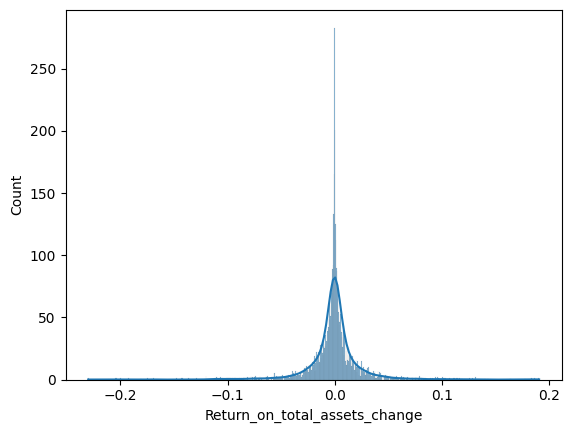

In [1042]:
sns.histplot(merged_df['Return_on_total_assets_change'], bins=1000, kde=True)

<Axes: xlabel='Return_on_total_assets_change', ylabel='Count'>

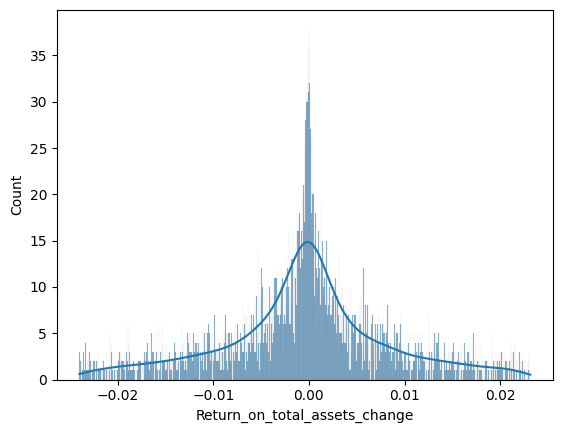

In [1043]:
#数据处理
# Calculate the first (Q1) and third (Q3) quartiles, and the interquartile range (IQR)
Q1 = merged_df['Return_on_total_assets_change'].quantile(0.25)
Q3 = merged_df['Return_on_total_assets_change'].quantile(0.75)
IQR = Q3 - Q1
# Define the outlier cutoff values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter out the outliers
filtered_df = merged_df[(merged_df['Return_on_total_assets_change'] >= lower_bound) & (merged_df['Return_on_total_assets_change'] <= upper_bound)]
sns.histplot(filtered_df['Return_on_total_assets_change'], bins=1000, kde=True)


## 0828营业能力改善
$$Revenue_i = a_i +β_iCost_i + ε_i $$
Revenue营业收入 Cost营业成本  
通过营业收入与营业成本线性关系的变化来反映公司营业能力的变化，回归的当季残差项的正负方向代表营业能力的变好与变差，绝对值代表变化幅度有多大。  

In [1131]:
#净利率
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREINCOME"])
All_data0828 = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREINCOME'][['m_anntime','m_timetag','revenue_inc','total_expense']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','revenue_inc','total_expense']]
    temp = temp[temp.m_timetag>='20180101']
    All_data0828 = All_data0828.append(temp)
    #All_data0828 = All_data0828.dropna()#去除了空值的股票
All_data0828['Year'] = All_data0828['m_timetag'].apply(lambda x:x[:4])
All_data0828 = All_data0828.groupby('ts_code').apply(lambda x:cal_factor_dif(x,'revenue_inc'))
All_data0828 = All_data0828.groupby('ts_code').apply(lambda x:cal_factor_dif(x,'total_expense'))
#N = 8,i=0,1,2...7
N = 8
# Z-score 标准化
scaler = StandardScaler()
All_data0828 = All_data0828.groupby('ts_code').apply(get_last_n_values,N=N)
All_data0828 = All_data0828.drop(All_data0828.columns[0], axis=1) 
#具体
scaled_data = pd.DataFrame()
scaler = StandardScaler()
#对每组股票分别对N季度进行标准化
for name, group in All_data0828.groupby('ts_code'):
    scaler.fit(group[['revenue_inc_diff', 'total_expense_diff']])
    group[['revenue_inc_diff', 'total_expense_diff']] = scaler.transform(group[['revenue_inc_diff', 'total_expense_diff']])
    scaled_data = pd.concat([scaled_data, group])

In [1132]:
All_data0828

m_anntime m_timetag   revenue_inc  total_expense  Year  \
ts_code                                                                
000001.SZ 101  20220818  20220630  9.202200e+10   6.406100e+10  2022   
          102  20221025  20220930  1.382650e+11   9.197000e+10  2022   
...                 ...       ...           ...            ...   ...   
688981.SH 21   20240329  20231231  4.525042e+10   3.534630e+10  2023   
          22   20240510  20240331  1.259378e+10   1.080728e+10  2024   

               revenue_inc_diff  total_expense_diff  
ts_code                                              
000001.SZ 101      4.581500e+10        3.419400e+10  
          102      4.624300e+10        2.790900e+10  
...                         ...                 ...  
688981.SH 21       1.215218e+10        9.864350e+09  
          22       1.259378e+10        1.080728e+10  

[2400 rows x 7 columns]

In [1133]:
# 线性回归，每组中每8个值进行回归分析
residuals = []
for name, group in scaled_data.groupby('ts_code'):
    for i in range(0, len(group), 8):
        sub_group = group.iloc[i:i+8]
        if len(sub_group) < 8:
            continue
        X = sub_group['total_expense_diff']
        y = sub_group['revenue_inc_diff']
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        residual = model.resid  # 提取残差
        residuals.append(residual)
residuals_df = pd.concat(residuals)
scaled_data['ε'] = residuals_df

#scaled_data = scaled_data.groupby('ts_code').last().reset_index()


In [1134]:
scaled_data

m_anntime m_timetag   revenue_inc  total_expense  Year  \
ts_code                                                                
000001.SZ 101  20220818  20220630  9.202200e+10   6.406100e+10  2022   
          102  20221025  20220930  1.382650e+11   9.197000e+10  2022   
...                 ...       ...           ...            ...   ...   
688981.SH 21   20240329  20231231  4.525042e+10   3.534630e+10  2023   
          22   20240510  20240331  1.259378e+10   1.080728e+10  2024   

               revenue_inc_diff  total_expense_diff         ε  
ts_code                                                        
000001.SZ 101          1.106318            1.586129  0.203140  
          102          1.235326            0.109595  1.172920  
...                         ...                 ...       ...  
688981.SH 21           0.239634            1.101830  0.009514  
          22           0.734373            2.007027  0.315200  

[2400 rows x 8 columns]

<Axes: xlabel='ε', ylabel='Count'>

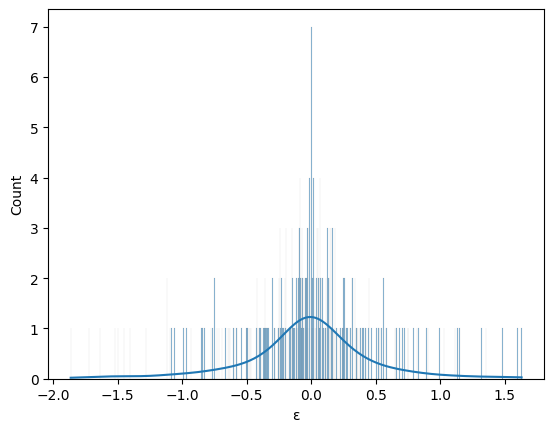

In [1047]:
sns.histplot(scaled_data['ε'], bins=1000, kde=True)

## 0826盈利市值比
$$\frac{最近12个月的归属母公司净利润(TTM)}{总市值}$$
说明为市盈率的倒数;用于衡量股价高低与公司盈利能力的估值因子，盈利市值比高的股票，说明公司盈利能力强，当前股价对应的投资回报率高，股价相对便宜。  

In [787]:
#净利润
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREINCOME"])
All_data = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREINCOME'][['m_anntime','m_timetag','net_profit_excl_min_int_inc']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','net_profit_excl_min_int_inc']]
    temp = temp[temp.m_timetag>='20180101']
    All_data = All_data.append(temp)
All_data['Year'] = All_data['m_timetag'].apply(lambda x:x[:4])
All_data['Month'] = All_data['m_timetag'].apply(lambda x:x[4:6])
All_data = All_data.groupby('ts_code').apply(lambda x:cal_factor_ttm(x,'net_profit_excl_min_int_inc'))
#All_data = All_data.dropna()#dropna数据就变了
#All_data = All_data.groupby('ts_code').apply(lambda x: x.tail(1))

In [788]:
All_data

,ts_code,m_anntime,m_timetag,net_profit_excl_min_int_inc,Year,Month,net_profit_excl_min_int_inc_diff,net_profit_excl_min_int_inc_TTM
84,000001.SZ,20180420,20180331,6.595000e+09,2018,03,6.595000e+09,NaN
85,000001.SZ,20180816,20180630,1.337200e+10,2018,06,6.777000e+09,NaN
...,...,...,...,...,...,...,...,...
21,688981.SH,20240329,20231231,4.822814e+09,2023,12,1.148030e+09,4.822814e+09
22,688981.SH,20240510,20240331,5.089590e+08,2024,03,5.089590e+08,3.740449e+09


In [789]:
#总市值
stock_price = get_price(ts_code_list = hs300_list,feature_list = ['total_mv'],
start_date='20180101',trade_date = '20240801',back_len = 1,target_type='stock')
stock_price = stock_price.sort_index(ascending=True)
stock_price

total_mv
trade_date ts_code              
2018-01-02 000001.SZ  23523500.0
           000002.SZ  35943500.0
...                          ...
2024-08-01 688599.SH   3711460.0
           688981.SH  39073500.0

[442804 rows x 1 columns]

In [790]:
#内连接
All_data['m_anntime'] = pd.to_datetime(All_data['m_anntime'])
merged_df = pd.merge(All_data, stock_price, how='inner', left_on=['ts_code', 'm_anntime'], right_on=['ts_code', 'trade_date'])
merged_df['Profit_to_market_ratio'] = merged_df['net_profit_excl_min_int_inc_TTM']/merged_df['total_mv']
merged_df = merged_df.dropna()
merged_df[merged_df.ts_code == '000001.SZ']

,ts_code,m_anntime,m_timetag,net_profit_excl_min_int_inc,Year,Month,net_profit_excl_min_int_inc_diff,net_profit_excl_min_int_inc_TTM,total_mv,Profit_to_market_ratio
3,000001.SZ,2019-03-07,20181231,2.481800e+10,2018,12,4.362000e+09,2.481800e+10,21875100.0,1134.531956
4,000001.SZ,2019-04-24,20190331,7.446000e+09,2019,03,7.446000e+09,2.566900e+10,24794100.0,1035.286621
...,...,...,...,...,...,...,...,...,...,...
22,000001.SZ,2023-10-25,20230930,3.963500e+10,2023,09,1.424800e+10,4.849200e+10,20143300.0,2407.351328
23,000001.SZ,2024-03-15,20231231,4.645500e+10,2023,12,6.820000e+09,4.645500e+10,20570300.0,2258.353062


In [791]:
merged_df

,ts_code,m_anntime,m_timetag,net_profit_excl_min_int_inc,Year,Month,net_profit_excl_min_int_inc_diff,net_profit_excl_min_int_inc_TTM,total_mv,Profit_to_market_ratio
3,000001.SZ,2019-03-07,20181231,2.481800e+10,2018,12,4.362000e+09,2.481800e+10,21875100.0,1134.531956
4,000001.SZ,2019-04-24,20190331,7.446000e+09,2019,03,7.446000e+09,2.566900e+10,24794100.0,1035.286621
...,...,...,...,...,...,...,...,...,...,...
5384,688981.SH,2024-03-29,20231231,4.822814e+09,2023,12,1.148030e+09,4.822814e+09,34704100.0,138.969574
5385,688981.SH,2024-05-10,20240331,5.089590e+08,2024,03,5.089590e+08,3.740449e+09,34196700.0,109.380408


<Axes: xlabel='Profit_to_market_ratio', ylabel='Count'>

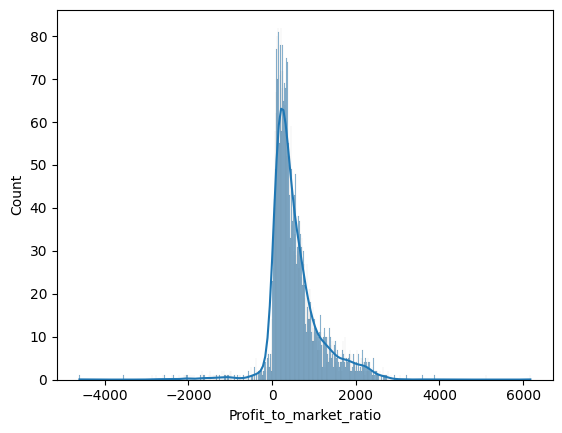

In [792]:
sns.histplot(merged_df['Profit_to_market_ratio'], bins=1000, kde=True)

## 0822账面市值比（去杠杆后）
$$\frac{最近报告期的经营性净资产}{当日经管性净资产市值} $$
其中  
$$经营性净资产=股东权益+净负债=股东权益合计(含少数股东权益)+金融负债金融资产 $$ 
$$经营性净资产市值=金融负债-金融资产+市值$$
说明  
改进后的市净率倒数，对企业估值更合理准确，选股能力显著提高，分子分母都使用了经营性资产相关指标，对债权和股权都做了市场定价，而且剥离了企业金融性活动的影响，更准确反映企业核心资产

##### 金融负债：金融负债=短期借款+长期借款+应付债券+应付票据+租赁负债+其他金融负债

In [793]:
#短期借款,长期借款,应付债券,应付票据,负债合计?
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREBALANCESHEET"])
All_data1 = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREBALANCESHEET'][['m_anntime','m_timetag','shortterm_loan','long_term_loans','bonds_payable','notes_payable','tot_liab',]]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','shortterm_loan','long_term_loans','bonds_payable','notes_payable','tot_liab']]
    temp = temp[temp.m_timetag>='20180101']
    All_data1 = All_data1.append(temp)
    All_data1.fillna(0, inplace=True)
    #All_data1 = All_data1.dropna()#去除了空值的股票
#All_data1

In [794]:
#金融负债
All_data1['Financial_liabilities'] = All_data1['shortterm_loan']+All_data1['long_term_loans']+All_data1['bonds_payable']+All_data1['notes_payable']+All_data1['tot_liab']

In [795]:
All_data1

,ts_code,m_anntime,m_timetag,shortterm_loan,long_term_loans,bonds_payable,notes_payable,tot_liab,Financial_liabilities
84,000001.SZ,20180420,20180331,0.000000e+00,0.000000e+00,3.579680e+11,0.0,3.115181e+12,3.473149e+12
85,000001.SZ,20180816,20180630,0.000000e+00,0.000000e+00,3.615390e+11,0.0,3.139258e+12,3.500797e+12
...,...,...,...,...,...,...,...,...,...
18,688981.SH,20240329,20231231,3.397576e+09,5.903181e+10,4.243352e+09,0.0,1.199930e+11,1.866657e+11
19,688981.SH,20240510,20240331,3.901200e+09,5.802713e+10,4.252048e+09,0.0,1.230401e+11,1.892205e+11


##### 金融资产：金融资产=现金及现金等价物+交易性金融资产+应收账款+应收票据+持有至到期投资+可供出售金融资产+贷款和应收款项+其他金融资产

In [796]:
#货币资金，交易性金融资产,应收账款,应收票据,持有至到期投资,可供出售金融资产,资产总计?
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREBALANCESHEET"])
All_data2 = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREBALANCESHEET'][['m_anntime','m_timetag','cash_equivalents','tradable_fin_assets','account_receivable','bill_receivable','held_to_mty_invest','fin_assets_avail_for_sale','tot_assets']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','cash_equivalents','tradable_fin_assets','account_receivable','bill_receivable','held_to_mty_invest','fin_assets_avail_for_sale','tot_assets']]
    temp = temp[temp.m_timetag>='20180101']
    All_data2 = All_data2.append(temp)
    All_data2.fillna(0, inplace=True)
    #All_data2 = All_data2.dropna()#去除了空值的股票
#All_data2

In [797]:
#金融资产
All_data2['Financial_assets'] = All_data2['cash_equivalents']+All_data2['tradable_fin_assets']+All_data2['account_receivable']+All_data2['bill_receivable']+All_data2['held_to_mty_invest']+All_data2['fin_assets_avail_for_sale']+All_data2['tot_assets']

In [798]:
All_data2

,ts_code,m_anntime,m_timetag,cash_equivalents,tradable_fin_assets,account_receivable,bill_receivable,held_to_mty_invest,fin_assets_avail_for_sale,tot_assets,Financial_assets
84,000001.SZ,20180420,20180331,2.819490e+11,7.684500e+10,0.000000e+00,0.0,0.0,0.0,3.338572e+12,3.697366e+12
85,000001.SZ,20180816,20180630,3.074000e+11,1.048930e+11,0.000000e+00,0.0,0.0,0.0,3.367399e+12,3.779692e+12
...,...,...,...,...,...,...,...,...,...,...,...
18,688981.SH,20240329,20231231,5.123537e+10,1.520160e+09,3.501291e+09,442456000.0,0.0,0.0,3.384632e+11,3.951625e+11
19,688981.SH,20240510,20240331,4.506591e+10,1.634212e+09,3.572115e+09,381828000.0,0.0,0.0,3.417577e+11,3.924118e+11


In [453]:
#总市值
stock_price = get_price(ts_code_list = hs300_list,feature_list = ['total_mv'],
start_date='20180101',trade_date = '20240801',back_len = 1,target_type='stock')
stock_price = stock_price.sort_index(ascending=True)
stock_price 

total_mv
trade_date ts_code              
2018-01-02 000001.SZ  23523500.0
           000002.SZ  35943500.0
           000063.SZ  14980400.0
           000100.SZ   5284350.0
           000157.SZ   3546290.0
...                          ...
2024-08-01 688303.SH   4242690.0
           688363.SH   2957020.0
           688396.SH   5312600.0
           688599.SH   3711460.0
           688981.SH  39073500.0

[442804 rows x 1 columns]

In [799]:
#连接
merged_df = pd.merge(All_data1,All_data2 ,how='inner', left_on=['ts_code','m_anntime','m_timetag'], right_on=['ts_code','m_anntime','m_timetag'])
merged_df['m_anntime'] = pd.to_datetime(merged_df['m_anntime'])
merged_df1 = pd.merge(merged_df, stock_price, how='inner', left_on=['ts_code', 'm_anntime'], right_on=['ts_code', 'trade_date'])

In [800]:
#经营性净资产市值（b）
merged_df1['Market_value_of_operating_net_assets'] = merged_df1['Financial_liabilities']-merged_df1['Financial_assets']+merged_df1['total_mv']

In [801]:
#股东权益合计（负债和股东权益总计-负债合计）
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREBALANCESHEET"])
All_data3 = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREBALANCESHEET'][['m_anntime','m_timetag','tot_liab_shrhldr_eqy','tot_liab']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','tot_liab_shrhldr_eqy','tot_liab']]
    temp = temp[temp.m_timetag>='20180101']
    All_data3 = All_data3.append(temp)
    All_data3.fillna(0, inplace=True)
    #All_data3 = All_data3.dropna()#去除了空值的股票
#All_data3

In [802]:
#连接
All_data3['m_anntime'] = pd.to_datetime(All_data3['m_anntime'])
merged_df2 = pd.merge(merged_df,All_data3,how='inner', left_on=['ts_code','m_anntime','m_timetag'], right_on=['ts_code','m_anntime','m_timetag'])
#经营性净资产（a）
merged_df2['Operating_net_assets'] = merged_df2['tot_liab_shrhldr_eqy'] - merged_df2['tot_liab_y'] + merged_df2['Financial_liabilities'] - merged_df2['Financial_assets']

In [803]:
merged_df1

,ts_code,m_anntime,m_timetag,shortterm_loan,long_term_loans,bonds_payable,notes_payable,tot_liab,Financial_liabilities,cash_equivalents,tradable_fin_assets,account_receivable,bill_receivable,held_to_mty_invest,fin_assets_avail_for_sale,tot_assets,Financial_assets,total_mv,Market_value_of_operating_net_assets
0,000001.SZ,2018-04-20,20180331,0.000000e+00,0.000000e+00,3.579680e+11,0.0,3.115181e+12,3.473149e+12,2.819490e+11,7.684500e+10,0.000000e+00,0.0,0.0,0.0,3.338572e+12,3.697366e+12,19488400.0,-2.241975e+11
1,000001.SZ,2018-08-16,20180630,0.000000e+00,0.000000e+00,3.615390e+11,0.0,3.139258e+12,3.500797e+12,3.074000e+11,1.048930e+11,0.000000e+00,0.0,0.0,0.0,3.367399e+12,3.779692e+12,15075600.0,-2.788799e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5279,688981.SH,2024-03-29,20231231,3.397576e+09,5.903181e+10,4.243352e+09,0.0,1.199930e+11,1.866657e+11,5.123537e+10,1.520160e+09,3.501291e+09,442456000.0,0.0,0.0,3.384632e+11,3.951625e+11,34704100.0,-2.084621e+11
5280,688981.SH,2024-05-10,20240331,3.901200e+09,5.802713e+10,4.252048e+09,0.0,1.230401e+11,1.892205e+11,4.506591e+10,1.634212e+09,3.572115e+09,381828000.0,0.0,0.0,3.417577e+11,3.924118e+11,34196700.0,-2.031571e+11


In [804]:
#账面市值比（因子）
merged_df3 = pd.merge(merged_df1,merged_df2,how='inner', left_on=['ts_code','m_anntime','m_timetag','shortterm_loan','long_term_loans','bonds_payable','notes_payable','Financial_liabilities','cash_equivalents','account_receivable','bill_receivable','held_to_mty_invest','fin_assets_avail_for_sale','tot_assets'], right_on=['ts_code','m_anntime','m_timetag','shortterm_loan','long_term_loans','bonds_payable','notes_payable','Financial_liabilities','cash_equivalents','account_receivable','bill_receivable','held_to_mty_invest','fin_assets_avail_for_sale','tot_assets'])
merged_df3['book-to-market'] = merged_df3['Operating_net_assets']/merged_df3['Market_value_of_operating_net_assets']#a/b

In [805]:
merged_df3[merged_df3.ts_code == '688981.SH']

,ts_code,m_anntime,m_timetag,shortterm_loan,long_term_loans,bonds_payable,notes_payable,tot_liab,Financial_liabilities,cash_equivalents,...,Financial_assets_x,total_mv,Market_value_of_operating_net_assets,tot_liab_x,tradable_fin_assets_y,Financial_assets_y,tot_liab_shrhldr_eqy,tot_liab_y,Operating_net_assets,book-to-market
5267,688981.SH,2021-04-01,20191231,6.981170e+08,1.398778e+10,1.495177e+09,0.0,4.355804e+10,5.973911e+10,3.726847e+10,...,1.557716e+11,44148600.0,-9.598830e+10,4.355804e+10,3.000550e+08,1.557716e+11,1.148171e+11,4.355804e+10,-2.477342e+10,0.258088
5268,688981.SH,2021-04-01,20201231,2.956808e+09,2.633104e+10,5.469756e+09,0.0,6.296570e+10,9.772330e+10,8.666787e+10,...,2.949316e+11,44148600.0,-1.971642e+11,6.296570e+10,7.282250e+08,2.949316e+11,2.046017e+11,6.296570e+10,-5.557239e+10,0.281858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5279,688981.SH,2024-03-29,20231231,3.397576e+09,5.903181e+10,4.243352e+09,0.0,1.199930e+11,1.866657e+11,5.123537e+10,...,3.951625e+11,34704100.0,-2.084621e+11,1.199930e+11,1.520160e+09,3.951625e+11,3.384632e+11,1.199930e+11,9.973461e+09,-0.047843
5280,688981.SH,2024-05-10,20240331,3.901200e+09,5.802713e+10,4.252048e+09,0.0,1.230401e+11,1.892205e+11,4.506591e+10,...,3.924118e+11,34196700.0,-2.031571e+11,1.230401e+11,1.634212e+09,3.924118e+11,3.417577e+11,1.230401e+11,1.552632e+10,-0.076425


In [806]:
merged_df3

,ts_code,m_anntime,m_timetag,shortterm_loan,long_term_loans,bonds_payable,notes_payable,tot_liab,Financial_liabilities,cash_equivalents,...,Financial_assets_x,total_mv,Market_value_of_operating_net_assets,tot_liab_x,tradable_fin_assets_y,Financial_assets_y,tot_liab_shrhldr_eqy,tot_liab_y,Operating_net_assets,book-to-market
0,000001.SZ,2018-04-20,20180331,0.000000e+00,0.000000e+00,3.579680e+11,0.0,3.115181e+12,3.473149e+12,2.819490e+11,...,3.697366e+12,19488400.0,-2.241975e+11,3.115181e+12,7.684500e+10,3.697366e+12,3.338572e+12,3.115181e+12,-8.260000e+08,0.003684
1,000001.SZ,2018-08-16,20180630,0.000000e+00,0.000000e+00,3.615390e+11,0.0,3.139258e+12,3.500797e+12,3.074000e+11,...,3.779692e+12,15075600.0,-2.788799e+11,3.139258e+12,1.048930e+11,3.779692e+12,3.367399e+12,3.139258e+12,-5.075400e+10,0.181992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5279,688981.SH,2024-03-29,20231231,3.397576e+09,5.903181e+10,4.243352e+09,0.0,1.199930e+11,1.866657e+11,5.123537e+10,...,3.951625e+11,34704100.0,-2.084621e+11,1.199930e+11,1.520160e+09,3.951625e+11,3.384632e+11,1.199930e+11,9.973461e+09,-0.047843
5280,688981.SH,2024-05-10,20240331,3.901200e+09,5.802713e+10,4.252048e+09,0.0,1.230401e+11,1.892205e+11,4.506591e+10,...,3.924118e+11,34196700.0,-2.031571e+11,1.230401e+11,1.634212e+09,3.924118e+11,3.417577e+11,1.230401e+11,1.552632e+10,-0.076425


<Axes: xlabel='book-to-market', ylabel='Count'>

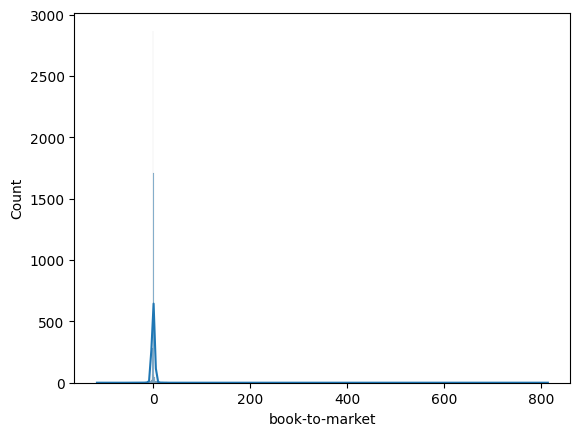

In [807]:
sns.histplot(merged_df3['book-to-market'], bins=1000, kde=True)

<Axes: xlabel='book-to-market', ylabel='Count'>

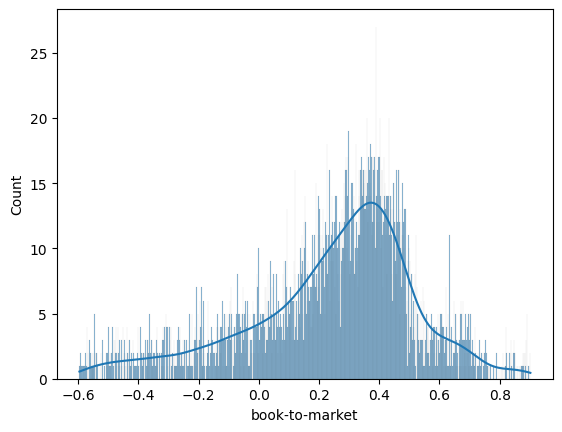

In [808]:
#数据处理
# Calculate the first (Q1) and third (Q3) quartiles, and the interquartile range (IQR)
Q1 = merged_df3['book-to-market'].quantile(0.25)
Q3 = merged_df3['book-to-market'].quantile(0.75)
IQR = Q3 - Q1
# Define the outlier cutoff values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter out the outliers
filtered_df = merged_df3[(merged_df3['book-to-market'] >= lower_bound) & (merged_df3['book-to-market'] <= upper_bound)]
sns.histplot(filtered_df['book-to-market'], bins=1000, kde=True)

## 0805日内收益率
$$intraday ret_t,_i=\frac{close_t,_i}{open_t,_i}-1$$
说明传统日度收益率可以划分为隔夜收益和日内收益，其中日内收益通常有一定程度的反转效应(对应日度收益率的反转);隔夜收益与日内收益两者存在显著的负相关关系，对未来收益的预测方向也往往相反，许多研究认为正是双方的反转关系削弱了总收益的表现。  

In [810]:
#开盘
stdata = xtdata.get_market_data_ex(
    field_list=['open'], stock_list=hs300_list, period='1d',
    start_time='20180101', end_time='', count=-1,
    dividend_type='front_ratio', fill_data=True
)
stocks = list(stdata.keys())
dates = list(stdata[stocks[0]].index)
data_array = np.zeros((len(dates), len(stocks)))
for i, stock in enumerate(stocks):
    data_array[:, i] = stdata[stock]['open'].values
df_opst = pd.DataFrame(data_array, index=[str(date) for date in dates], columns=stocks)

#收盘
stdata = xtdata.get_market_data_ex(
    field_list=['close'], stock_list=hs300_list, period='1d',
    start_time='20180101', end_time='', count=-1,
    dividend_type='front_ratio', fill_data=True
)
stocks = list(stdata.keys())
dates = list(stdata[stocks[0]].index)
data_array = np.zeros((len(dates), len(stocks)))
for i, stock in enumerate(stocks):
    data_array[:, i] = stdata[stock]['close'].values
df_clst = pd.DataFrame(data_array, index=[str(date) for date in dates], columns=stocks)

In [811]:
#计算日内收益率
ans = (df_clst/df_opst) - 1

In [812]:
ans

,000001.SZ,000002.SZ,000063.SZ,000100.SZ,000157.SZ,000166.SZ,000301.SZ,000333.SZ,000338.SZ,000408.SZ,...,688126.SH,688187.SH,688223.SH,688256.SH,688271.SH,688303.SH,688363.SH,688396.SH,688599.SH,688981.SH
20180102,0.026217,0.035294,-0.020559,0.007732,0.022472,0.001862,0.016949,0.004096,0.034731,0.002822,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180103,-0.029133,-0.005231,0.029750,0.023077,-0.002203,0.003738,-0.001848,-0.013437,-0.012687,0.022021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20240805,-0.005935,0.000000,-0.025283,-0.026247,-0.012195,-0.004386,-0.003871,-0.014231,-0.002326,-0.021691,...,-0.028387,-0.050035,-0.001437,-0.030762,0.020714,0.01540,0.020355,-0.015820,0.000000,-0.013764
20240806,-0.013903,0.004380,-0.003824,0.010724,0.001536,-0.006593,0.005135,-0.027431,-0.003077,-0.003600,...,-0.005898,-0.000370,0.020086,-0.019199,0.022962,0.04046,0.024518,-0.008418,0.039053,-0.009015


<Axes: ylabel='Count'>

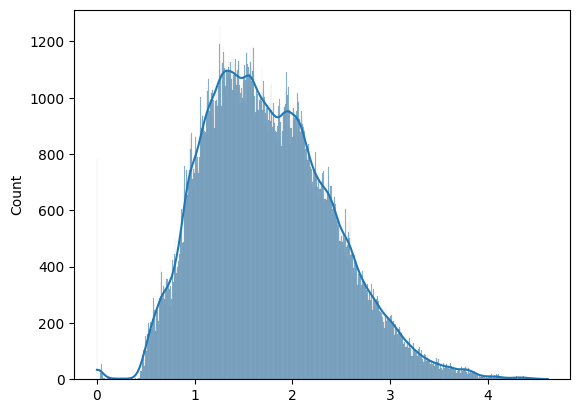

In [814]:
sns.histplot(result.select_dtypes(include=[int, float]).values.flatten(), bins=1000, kde=True)

## 0803非流动经营性资产变动
$$\frac{最近报告期的菲流动性经营资产-上年同期值}{平均总资产} $$
其中  
非流动性经营资产=非流动资产中期除金融资产相关科目后剩余的部分~=非流动资产-长期投资  
$$平均总资产=\frac{期初总资产+期末总资产}{2} $$
说明  
非流动性经营资产主要包括无形资产等分项，会计核算时也带有较大的主观性，容易涉及盈余操纵，可靠性较低，非流动性经营资产的变动与企业未来盈利负相关，与股票未来收益也负相关，容易造成错误定价

In [819]:
#非流动资产，长期投资(取得其他~)(全是空的)
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREBALANCESHEET"])
All_data = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREBALANCESHEET'][['m_anntime','m_timetag','other_non_mobile_assets','other_long_term_investments']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','other_non_mobile_assets','other_long_term_investments']]
    temp = temp[temp.m_timetag>='20180101']
    All_data = All_data.append(temp)
    All_data.fillna(0, inplace=True)
    #All_data = All_data.dropna()#去除了空值的股票

In [820]:
#总资产
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREBALANCESHEET"])
All_data1 = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREBALANCESHEET'][['m_anntime','m_timetag','tot_assets']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','tot_assets']]
    temp = temp[temp.m_timetag>='20180101']
    All_data1 = All_data1.append(temp)
    #All_data = All_data.dropna()#去除了空值的股票
#平均总资产（1年）
All_data1['Avg'] = All_data1.groupby('ts_code')['tot_assets'].apply(lambda x: (x + x.shift(4)) / 2)

In [833]:
#内连接
merged_df = pd.merge(All_data, All_data1, how='inner', left_on=['ts_code', 'm_anntime','m_timetag'], right_on=['ts_code', 'm_anntime','m_timetag'])
#非流动性经营资产变动
merged_df['Changes_in_non_current_operating_assets'] = ((merged_df['other_non_mobile_assets'] - merged_df['other_long_term_investments']) - (merged_df['other_non_mobile_assets'].shift(4) - merged_df['other_long_term_investments'].shift(4)))/merged_df['Avg']

In [822]:
merged_df[merged_df.ts_code == '000001.SZ']

,ts_code,m_anntime,m_timetag,other_non_mobile_assets,other_long_term_investments,tot_assets,Avg,Changes_in_non_current_operating_assets
0,000001.SZ,20180420,20180331,0.0,0.0,3.338572e+12,NaN,NaN
1,000001.SZ,20180816,20180630,0.0,0.0,3.367399e+12,NaN,NaN
...,...,...,...,...,...,...,...,...
23,000001.SZ,20240315,20231231,0.0,0.0,5.587116e+12,5.454315e+12,0.0
24,000001.SZ,20240420,20240331,0.0,0.0,5.729398e+12,5.592648e+12,0.0


In [823]:
merged_df

,ts_code,m_anntime,m_timetag,other_non_mobile_assets,other_long_term_investments,tot_assets,Avg,Changes_in_non_current_operating_assets
0,000001.SZ,20180420,20180331,0.000000e+00,0.0,3.338572e+12,NaN,NaN
1,000001.SZ,20180816,20180630,0.000000e+00,0.0,3.367399e+12,NaN,NaN
...,...,...,...,...,...,...,...,...
7158,688981.SH,20240329,20231231,5.070930e+10,0.0,3.384632e+11,3.217834e+11,0.035533
7159,688981.SH,20240510,20240331,4.762014e+10,0.0,3.417577e+11,3.259265e+11,0.027425


<Axes: xlabel='Changes_in_non_current_operating_assets', ylabel='Count'>

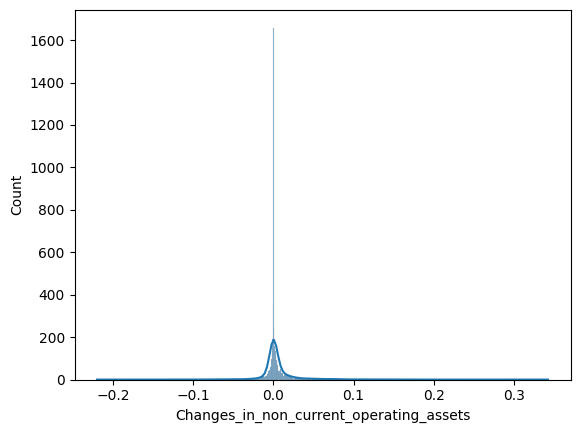

In [834]:
sns.histplot(merged_df['Changes_in_non_current_operating_assets'], bins=1000, kde=True)

<Axes: xlabel='Changes_in_non_current_operating_assets', ylabel='Count'>

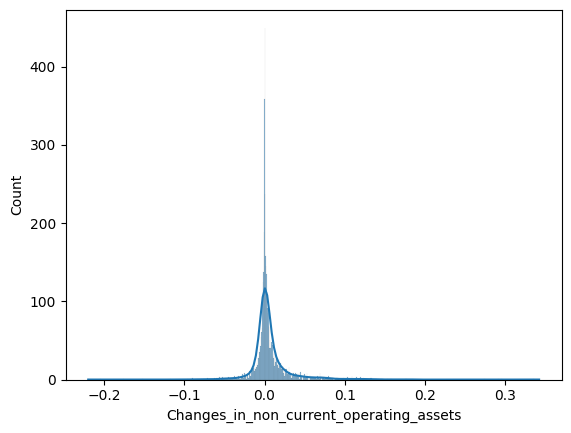

In [835]:
#数据处理
#去0
merged_df['Changes_in_non_current_operating_assets'].replace(0.0, np.nan, inplace=True)
sns.histplot(merged_df['Changes_in_non_current_operating_assets'], bins=1000, kde=True)

<Axes: xlabel='Changes_in_non_current_operating_assets', ylabel='Count'>

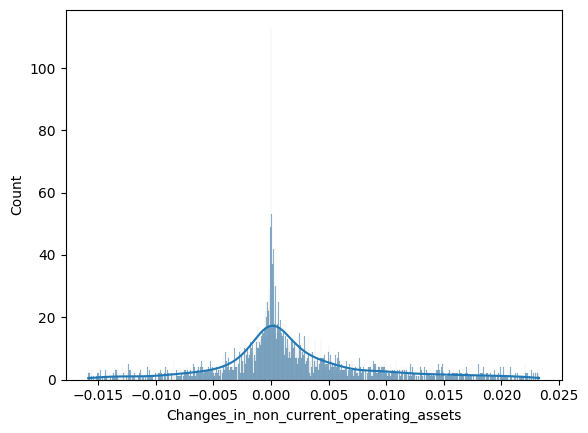

In [837]:
#数据处理
merged_df['Changes_in_non_current_operating_assets'].replace(0, np.nan, inplace=True)
# Calculate the first (Q1) and third (Q3) quartiles, and the interquartile range (IQR)
Q1 = merged_df['Changes_in_non_current_operating_assets'].quantile(0.25)
Q3 = merged_df['Changes_in_non_current_operating_assets'].quantile(0.75)
IQR = Q3 - Q1
# Define the outlier cutoff values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter out the outliers
filtered_df = merged_df[(merged_df['Changes_in_non_current_operating_assets'] >= lower_bound) & (merged_df['Changes_in_non_current_operating_assets'] <= upper_bound)]
sns.histplot(filtered_df['Changes_in_non_current_operating_assets'], bins=1000, kde=True)


## 0731现金流市值比（去杠杆）
$$\frac{最近12个月的经营性活动产生的现金流净额(TTM)}{当日经营性净资产市值} $$
其中
$$经营性净资产市值=金融负债-金融资产+市值$$
说明  
改进后的市现率倒数，对企业估值更合理准确，选股能力显著提高;计算时将“市值”替换成了“经营性净资产市值”，对债权和股权都做了市场定价，分子分母相匹配;而且剥离了企业金融性活动的影响，能更准确反映企业核心资产。

In [842]:
#现金流净额
financial_data = xtdata.get_financial_data(hs300_list,["ASHARECASHFLOW"])
All_data = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHARECASHFLOW'][['m_anntime','m_timetag','net_cash_flows_oper_act']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','net_cash_flows_oper_act']]
    temp = temp[temp.m_timetag>='20180101']
    All_data = All_data.append(temp)
    #All_data = All_data.dropna()#去除了空值的股票
#All_data


In [843]:
#TTM
All_data['Year'] = All_data['m_timetag'].apply(lambda x:x[:4])
All_data['Month'] = All_data['m_timetag'].apply(lambda x:x[4:6])
All_data = All_data.groupby('ts_code').apply(lambda x:cal_factor_ttm(x,'net_cash_flows_oper_act'))

In [1065]:
All_data

,ts_code,m_anntime,m_timetag,net_profit_incl_min_int_inc,Year,net_profit_incl_min_int_inc_diff,Quarterly_net_profit_year-on-year_growth_rate
84,000001.SZ,20180420,20180331,6.595000e+09,2018,6.595000e+09,NaN
85,000001.SZ,20180816,20180630,1.337200e+10,2018,6.777000e+09,NaN
...,...,...,...,...,...,...,...
21,688981.SH,20240329,20231231,4.822814e+09,2023,1.148030e+09,-0.581556
22,688981.SH,20240510,20240331,5.089590e+08,2024,5.089590e+08,-0.680166


In [844]:
#算经营性进资产市值

In [845]:
#短期借款,长期借款,应付债券,应付票据,负债合计?
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREBALANCESHEET"])
All_data1 = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREBALANCESHEET'][['m_anntime','m_timetag','shortterm_loan','long_term_loans','bonds_payable','notes_payable','tot_liab',]]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','shortterm_loan','long_term_loans','bonds_payable','notes_payable','tot_liab']]
    temp = temp[temp.m_timetag>='20180101']
    All_data1 = All_data1.append(temp)
    All_data1.fillna(0, inplace=True)
    #All_data1 = All_data1.dropna()#去除了空值的股票
#All_data1

In [846]:
#金融负债
All_data1['Financial_liabilities'] = All_data1['shortterm_loan']+All_data1['long_term_loans']+All_data1['bonds_payable']+All_data1['notes_payable']+All_data1['tot_liab']

In [847]:
#货币资金，交易性金融资产,应收账款,应收票据,持有至到期投资,可供出售金融资产,资产总计?
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREBALANCESHEET"])
All_data2 = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREBALANCESHEET'][['m_anntime','m_timetag','cash_equivalents','tradable_fin_assets','account_receivable','bill_receivable','held_to_mty_invest','fin_assets_avail_for_sale','tot_assets']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','cash_equivalents','tradable_fin_assets','account_receivable','bill_receivable','held_to_mty_invest','fin_assets_avail_for_sale','tot_assets']]
    temp = temp[temp.m_timetag>='20180101']
    All_data2 = All_data2.append(temp)
    All_data2.fillna(0, inplace=True)
    #All_data2 = All_data2.dropna()#去除了空值的股票
#All_data2

In [848]:
#金融资产
All_data2['Financial_assets'] = All_data2['cash_equivalents']+All_data2['tradable_fin_assets']+All_data2['account_receivable']+All_data2['bill_receivable']+All_data2['held_to_mty_invest']+All_data2['fin_assets_avail_for_sale']+All_data2['tot_assets']

In [849]:
#总市值
stock_price = get_price(ts_code_list = hs300_list,feature_list = ['total_mv'],
start_date='20180101',trade_date = '20240801',back_len = 1,target_type='stock')
stock_price = stock_price.sort_index(ascending=True)

In [850]:
#连接
merged_df = pd.merge(All_data1,All_data2 ,how='inner', left_on=['ts_code','m_anntime','m_timetag'], right_on=['ts_code','m_anntime','m_timetag'])
merged_df['m_anntime'] = pd.to_datetime(merged_df['m_anntime'])
merged_df1 = pd.merge(merged_df, stock_price, how='inner', left_on=['ts_code', 'm_anntime'], right_on=['ts_code', 'trade_date'])

In [851]:
#经营性净资产市值（b）
merged_df1['Market_value_of_operating_net_assets'] = merged_df1['Financial_liabilities']-merged_df1['Financial_assets']+merged_df1['total_mv']

In [852]:
#现金流市值比
All_data['m_anntime'] = pd.to_datetime(All_data['m_anntime'])
merged_df2 = pd.merge(All_data,merged_df1, how='inner', left_on=['ts_code','m_anntime','m_timetag'], right_on=['ts_code', 'm_anntime','m_timetag'])
merged_df2['Cash_flow_to_market_ratio'] = merged_df2['net_cash_flows_oper_act_TTM']/merged_df2['Market_value_of_operating_net_assets']

In [853]:
merged_df2[merged_df2.ts_code == '688981.SH']

,ts_code,m_anntime,m_timetag,net_cash_flows_oper_act,Year,Month,net_cash_flows_oper_act_diff,net_cash_flows_oper_act_TTM,shortterm_loan,long_term_loans,...,tradable_fin_assets,account_receivable,bill_receivable,held_to_mty_invest,fin_assets_avail_for_sale,tot_assets,Financial_assets,total_mv,Market_value_of_operating_net_assets,Cash_flow_to_market_ratio
4902,688981.SH,2021-04-01,20191231,8.139992e+09,2019,12,7.059331e+09,8.139992e+09,6.981170e+08,1.398778e+10,...,3.000550e+08,3.283285e+09,102682000.0,0.0,0.0,1.148171e+11,1.557716e+11,44148600.0,-9.598830e+10,-0.084802
4903,688981.SH,2020-08-28,20200630,3.093755e+09,2020,06,1.561860e+09,8.962931e+09,3.819380e+08,1.197312e+10,...,0.000000e+00,4.029181e+09,38344000.0,0.0,0.0,1.443636e+11,1.982840e+11,51376000.0,-1.291006e+11,-0.069426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4914,688981.SH,2024-03-29,20231231,2.304776e+10,2023,12,6.700235e+09,2.304776e+10,3.397576e+09,5.903181e+10,...,1.520160e+09,3.501291e+09,442456000.0,0.0,0.0,3.384632e+11,3.951625e+11,34704100.0,-2.084621e+11,-0.110561
4915,688981.SH,2024-05-10,20240331,3.566576e+09,2024,03,3.566576e+09,2.131419e+10,3.901200e+09,5.802713e+10,...,1.634212e+09,3.572115e+09,381828000.0,0.0,0.0,3.417577e+11,3.924118e+11,34196700.0,-2.031571e+11,-0.104915


In [854]:
merged_df2

,ts_code,m_anntime,m_timetag,net_cash_flows_oper_act,Year,Month,net_cash_flows_oper_act_diff,net_cash_flows_oper_act_TTM,shortterm_loan,long_term_loans,...,tradable_fin_assets,account_receivable,bill_receivable,held_to_mty_invest,fin_assets_avail_for_sale,tot_assets,Financial_assets,total_mv,Market_value_of_operating_net_assets,Cash_flow_to_market_ratio
0,000001.SZ,2018-04-20,20180331,4.144200e+10,2018,03,4.144200e+10,NaN,0.000000e+00,0.000000e+00,...,7.684500e+10,0.000000e+00,0.0,0.0,0.0,3.338572e+12,3.697366e+12,19488400.0,-2.241975e+11,NaN
1,000001.SZ,2018-08-16,20180630,7.455000e+09,2018,06,-3.398700e+10,NaN,0.000000e+00,0.000000e+00,...,1.048930e+11,0.000000e+00,0.0,0.0,0.0,3.367399e+12,3.779692e+12,15075600.0,-2.788799e+11,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4914,688981.SH,2024-03-29,20231231,2.304776e+10,2023,12,6.700235e+09,2.304776e+10,3.397576e+09,5.903181e+10,...,1.520160e+09,3.501291e+09,442456000.0,0.0,0.0,3.384632e+11,3.951625e+11,34704100.0,-2.084621e+11,-0.110561
4915,688981.SH,2024-05-10,20240331,3.566576e+09,2024,03,3.566576e+09,2.131419e+10,3.901200e+09,5.802713e+10,...,1.634212e+09,3.572115e+09,381828000.0,0.0,0.0,3.417577e+11,3.924118e+11,34196700.0,-2.031571e+11,-0.104915


<Axes: xlabel='Cash_flow_to_market_ratio', ylabel='Count'>

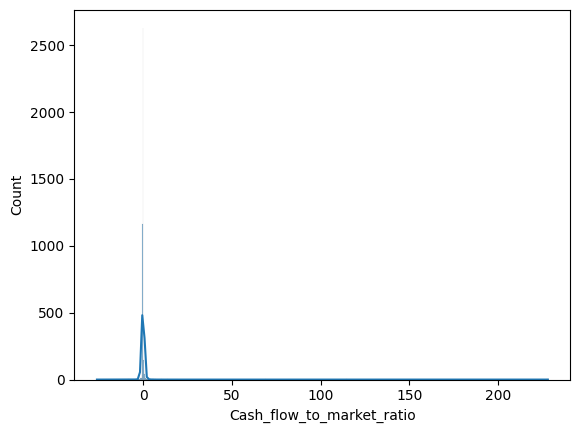

In [855]:
sns.histplot(merged_df2['Cash_flow_to_market_ratio'], bins=1000, kde=True)

<Axes: xlabel='Cash_flow_to_market_ratio', ylabel='Count'>

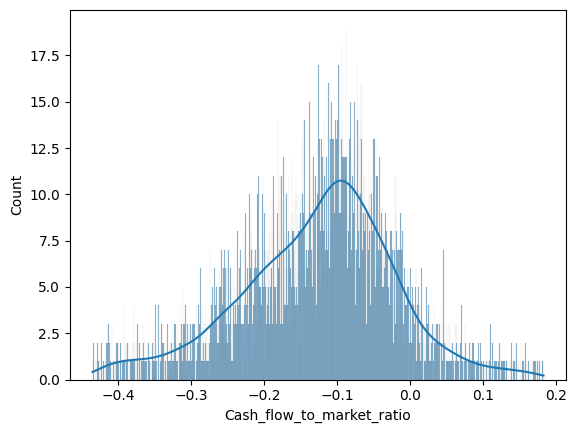

In [858]:
#数据处理
# Calculate the first (Q1) and third (Q3) quartiles, and the interquartile range (IQR)
Q1 = merged_df2['Cash_flow_to_market_ratio'].quantile(0.25)
Q3 = merged_df2['Cash_flow_to_market_ratio'].quantile(0.75)
IQR = Q3 - Q1
# Define the outlier cutoff values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter out the outliers
filtered_df = merged_df2[(merged_df2['Cash_flow_to_market_ratio'] >= lower_bound) & (merged_df2['Cash_flow_to_market_ratio'] <= upper_bound)]
sns.histplot(filtered_df['Cash_flow_to_market_ratio'], bins=1000, kde=True)

## 0729对流流通市值
$$ln(当日收盘价 X 当日自由流通股本)=ln(总市值)$$
说明A股市值分布存在严重厚为特征，取对数后，会使得因子分布更接近正态分布。  

In [659]:
#总市值
stock_price = get_price(ts_code_list = hs300_list,feature_list = ['total_mv'],
start_date='20180101',trade_date = '20240801',back_len = 1,target_type='stock')
stock_price = stock_price.sort_index(ascending=True)
stock_price 

total_mv
trade_date ts_code              
2018-01-02 000001.SZ  23523500.0
           000002.SZ  35943500.0
           000063.SZ  14980400.0
           000100.SZ   5284350.0
           000157.SZ   3546290.0
...                          ...
2024-08-01 688303.SH   4242690.0
           688363.SH   2957020.0
           688396.SH   5312600.0
           688599.SH   3711460.0
           688981.SH  39073500.0

[442804 rows x 1 columns]

<Axes: xlabel='total_mv', ylabel='Count'>

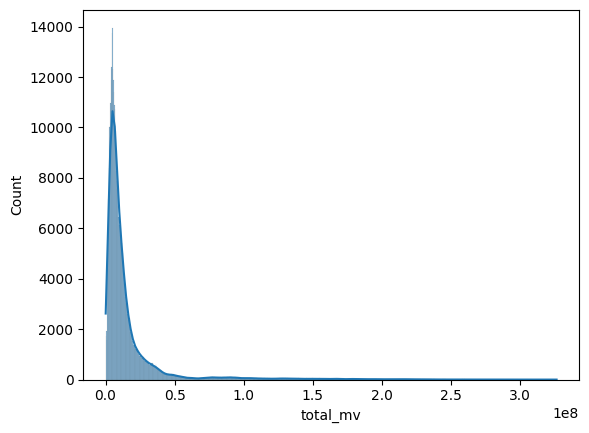

In [859]:
sns.histplot(stock_price ['total_mv'], bins=1000, kde=True)

In [860]:
#计算ln
stock_price['Logarithmic_circulating_market_value'] = np.log(stock_price['total_mv'])

In [861]:
stock_price

total_mv  Logarithmic_circulating_market_value
trade_date ts_code                                                    
2018-01-02 000001.SZ  23523500.0                             16.973510
           000002.SZ  35943500.0                             17.397459
...                          ...                                   ...
2024-08-01 688599.SH   3711460.0                             15.126936
           688981.SH  39073500.0                             17.480955

[442804 rows x 2 columns]

<Axes: xlabel='Logarithmic_circulating_market_value', ylabel='Count'>

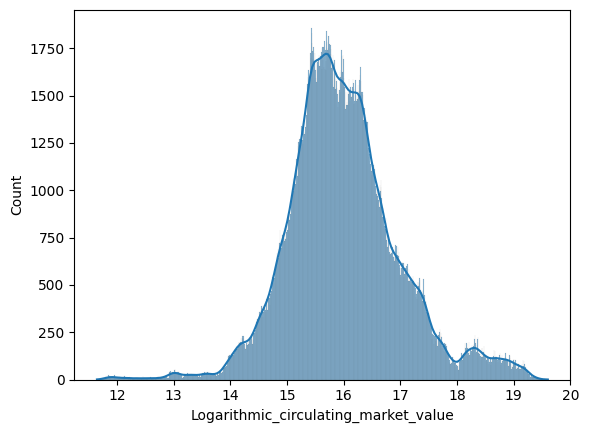

In [862]:
sns.histplot(stock_price ['Logarithmic_circulating_market_value'], bins=1000, kde=True)

## 0723流动性经营负债变动
$$\frac{最近报告期的流动性经营负债-上年同期值}{平均总资产}$$
其中  
流动性经营负债=流动负债中剔除金融负债相关科目后剩余的部分≈流动负债-(短期借款+交易性金融负债+应付票据+一年内到期的非流动负债)  
$$平均总资产=\frac{期初总资产+期末总资产}{2}$$  
说明  
流动性经营负债主要指流动性负债中的各类应付款项，对应的是企业的财务义务，可靠性高，盈余操作空间小，与股票未来收益正相关，

In [863]:
#流动负债（合计），短期借款，交易金融负债，应付票据，一年交易性资产
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREBALANCESHEET"])
All_data = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREBALANCESHEET'][['m_anntime','m_timetag','total_current_liability','shortterm_loan','tradable_fin_liab','notes_payable','current_assets_one_year']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','total_current_liability','shortterm_loan','tradable_fin_liab','notes_payable','current_assets_one_year']]
    temp = temp[temp.m_timetag>='20180101']
    All_data = All_data.append(temp)
    All_data.fillna(0, inplace=True)
    #All_data = All_data.dropna()#去除了空值的股票

In [864]:
#流动性经营负债
All_data['Liquidity_operating_liabilities'] = All_data['total_current_liability'] - (All_data['shortterm_loan']+All_data['tradable_fin_liab']+All_data['notes_payable']+All_data['current_assets_one_year'])

In [865]:
#总资产
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREBALANCESHEET"])
All_data1 = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREBALANCESHEET'][['m_anntime','m_timetag','tot_assets']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','tot_assets']]
    temp = temp[temp.m_timetag>='20180101']
    All_data1 = All_data1.append(temp)
    #All_data = All_data.dropna()#去除了空值的股票
#平均总资产（1年）
All_data1['Avg'] = All_data1.groupby('ts_code')['tot_assets'].apply(lambda x: (x + x.shift(4)) / 2)

In [866]:
#内连接
merged_df = pd.merge(All_data, All_data1, how='inner', left_on=['ts_code', 'm_anntime','m_timetag'], right_on=['ts_code', 'm_anntime','m_timetag'])
##流动性经营负债变动
merged_df['Changes_in_current_operating_liabilities'] = (merged_df['Liquidity_operating_liabilities'] - merged_df['Liquidity_operating_liabilities'].shift(4))/merged_df['Avg']

In [867]:
#由于流动负债（合计），短期借款，应付票据，一年交易性资产为NaN,结果也为NaN

In [868]:
merged_df[merged_df.ts_code == '000001.SZ']

,ts_code,m_anntime,m_timetag,total_current_liability,shortterm_loan,tradable_fin_liab,notes_payable,current_assets_one_year,Liquidity_operating_liabilities,tot_assets,Avg,Changes_in_current_operating_liabilities
0,000001.SZ,20180420,20180331,0.0,0.0,1.141300e+10,0.0,0.0,-1.141300e+10,3.338572e+12,NaN,NaN
1,000001.SZ,20180816,20180630,0.0,0.0,8.614000e+09,0.0,0.0,-8.614000e+09,3.367399e+12,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
23,000001.SZ,20240315,20231231,0.0,0.0,3.161400e+10,0.0,0.0,-3.161400e+10,5.587116e+12,5.454315e+12,0.006864
24,000001.SZ,20240420,20240331,0.0,0.0,4.722100e+10,0.0,0.0,-4.722100e+10,5.729398e+12,5.592648e+12,0.005557


In [869]:
merged_df

,ts_code,m_anntime,m_timetag,total_current_liability,shortterm_loan,tradable_fin_liab,notes_payable,current_assets_one_year,Liquidity_operating_liabilities,tot_assets,Avg,Changes_in_current_operating_liabilities
0,000001.SZ,20180420,20180331,0.000000e+00,0.000000e+00,1.141300e+10,0.0,0.000000e+00,-1.141300e+10,3.338572e+12,NaN,NaN
1,000001.SZ,20180816,20180630,0.000000e+00,0.000000e+00,8.614000e+09,0.0,0.000000e+00,-8.614000e+09,3.367399e+12,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7158,688981.SH,20240329,20231231,5.261373e+10,3.397576e+09,0.000000e+00,0.0,1.512531e+10,3.409084e+10,3.384632e+11,3.217834e+11,0.015683
7159,688981.SH,20240510,20240331,5.673057e+10,3.901200e+09,0.000000e+00,0.0,1.690765e+10,3.592172e+10,3.417577e+11,3.259265e+11,0.027738


<Axes: xlabel='Changes_in_current_operating_liabilities', ylabel='Count'>

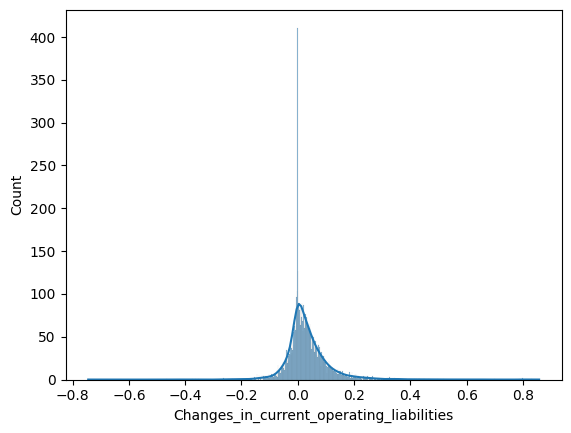

In [870]:
sns.histplot(merged_df['Changes_in_current_operating_liabilities'], bins=1000, kde=True)

<Axes: xlabel='Changes_in_current_operating_liabilities', ylabel='Count'>

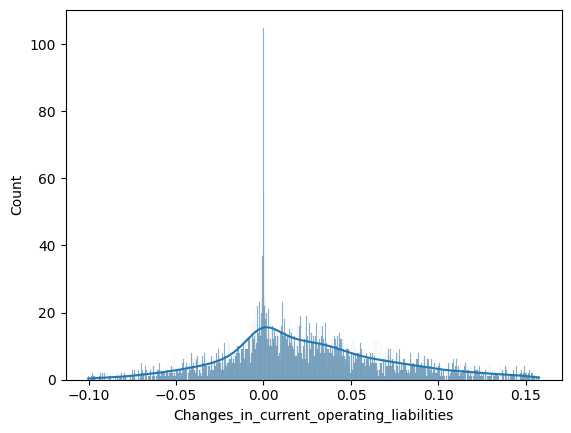

In [872]:
#数据处理
# Calculate the first (Q1) and third (Q3) quartiles, and the interquartile range (IQR)
Q1 = merged_df['Changes_in_current_operating_liabilities'].quantile(0.25)
Q3 = merged_df['Changes_in_current_operating_liabilities'].quantile(0.75)
IQR = Q3 - Q1
# Define the outlier cutoff values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter out the outliers
filtered_df = merged_df[(merged_df['Changes_in_current_operating_liabilities'] >= lower_bound) & (merged_df['Changes_in_current_operating_liabilities'] <= upper_bound)]
sns.histplot(filtered_df['Changes_in_current_operating_liabilities'], bins=1000, kde=True)

## 1225盈余公告股票跳动
$$\frac{公告披露后下一日开盘价}{公告日收盘价}-1$$
说明  
盈余公告跳动反映了盈余公告对股价带来的冲击，正向跳空说明盈余超预期，负向跳空说明盈余低预期。

In [873]:
#公告日
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREINCOME"])
All_data = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREINCOME'][['m_anntime']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime']]
    temp = temp[temp.m_anntime>='20180101']
    All_data = All_data.append(temp)

In [874]:
All_data

,ts_code,m_anntime
80,000001.SZ,20180420
81,000001.SZ,20180816
...,...,...
21,688981.SH,20240329
22,688981.SH,20240510


In [875]:
#收盘
stdata = xtdata.get_market_data_ex(
    field_list=['close'], stock_list=hs300_list, period='1d',
    start_time='20180101', end_time='', count=-1,
    dividend_type='front', fill_data=True
)
stocks = list(stdata.keys())
dates = list(stdata[stocks[0]].index)
data_array = np.zeros((len(dates), len(stocks)))
for i, stock in enumerate(stocks):
    data_array[:, i] = stdata[stock]['close'].values
df_clst = pd.DataFrame(data_array, index=[str(date) for date in dates], columns=stocks)
df_clst.index.name = 'time'
# 处理
df_clst = df_clst.stack().reset_index()
df_clst.columns = ['time', 'ts_code', 'close']
df_clst = df_clst[['ts_code', 'time', 'close']]
df_clst = df_clst.sort_values(by=['ts_code', 'time'])

In [876]:
df_clst

,ts_code,time,close
0,000001.SZ,20180102,11.789
236,000001.SZ,20180103,11.419
...,...,...,...
445901,688981.SH,20240805,47.290
446201,688981.SH,20240806,47.270


In [877]:
#开盘
stdata = xtdata.get_market_data_ex(
    field_list=['open'], stock_list=hs300_list, period='1d',
    start_time='20180101', end_time='', count=-1,
    dividend_type='front', fill_data=True
)
stocks = list(stdata.keys())
dates = list(stdata[stocks[0]].index)
data_array = np.zeros((len(dates), len(stocks)))
for i, stock in enumerate(stocks):
    data_array[:, i] = stdata[stock]['open'].values
df_opst = pd.DataFrame(data_array, index=[str(date) for date in dates], columns=stocks)
df_opst.index.name = 'time'
# 处理
df_opst = df_opst.stack().reset_index()
df_opst.columns = ['time', 'ts_code', 'open']
df_opst = df_opst[['ts_code', 'time', 'open']]
df_opst = df_opst.sort_values(by=['ts_code', 'time'])

In [878]:
df_opst

,ts_code,time,open
0,000001.SZ,20180102,11.439
236,000001.SZ,20180103,11.819
...,...,...,...
445901,688981.SH,20240805,47.950
446201,688981.SH,20240806,47.700


In [879]:
merged_df = pd.merge(All_data,df_clst, how='inner', left_on=['ts_code', 'm_anntime'], right_on=['ts_code', 'time'])
merged_df1 = pd.merge(merged_df,df_opst, how='inner', left_on=['ts_code', 'm_anntime',], right_on=['ts_code', 'time'])
merged_df1.drop(['time_x', 'time_y'], axis=1, inplace=False)
merged_df1['Earnings_Announcement_Stock_Bounce'] = merged_df1['open'].shift(-1)/merged_df1['close'] - 1

In [880]:
merged_df1

,ts_code,m_anntime,time_x,close,time_y,open,Earnings_Announcement_Stock_Bounce
0,000001.SZ,20180420,20180420,9.439,20180420,9.599,0.016951
1,000001.SZ,20180420,20180420,9.439,20180420,9.599,-0.263163
...,...,...,...,...,...,...,...
6195,688981.SH,20240329,20240329,43.660,20240329,43.930,0.000916
6196,688981.SH,20240510,20240510,42.990,20240510,43.700,NaN


<Axes: xlabel='Earnings_Announcement_Stock_Bounce', ylabel='Count'>

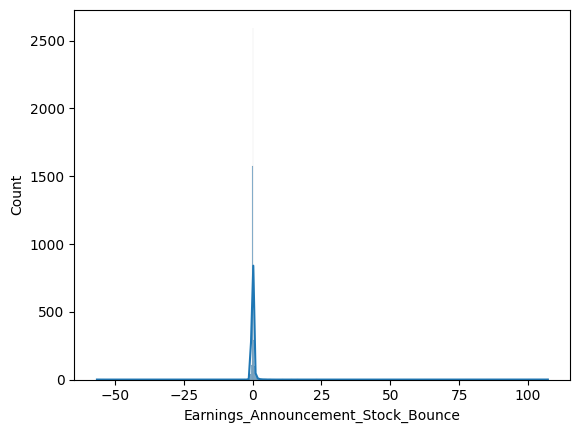

In [881]:
sns.histplot(merged_df1['Earnings_Announcement_Stock_Bounce'], bins=1000, kde=True)

<Axes: xlabel='Earnings_Announcement_Stock_Bounce', ylabel='Count'>

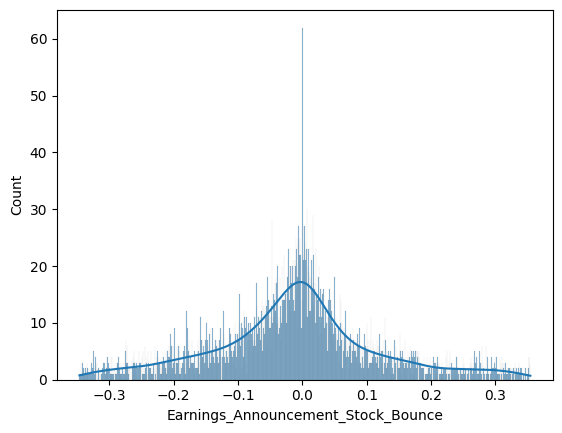

In [883]:
#数据处理
# Calculate the first (Q1) and third (Q3) quartiles, and the interquartile range (IQR)
Q1 = merged_df1['Earnings_Announcement_Stock_Bounce'].quantile(0.25)
Q3 = merged_df1['Earnings_Announcement_Stock_Bounce'].quantile(0.75)
IQR = Q3 - Q1
# Define the outlier cutoff values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter out the outliers
filtered_df = merged_df1[(merged_df1['Earnings_Announcement_Stock_Bounce'] >= lower_bound) & (merged_df1['Earnings_Announcement_Stock_Bounce'] <= upper_bound)]
sns.histplot(filtered_df['Earnings_Announcement_Stock_Bounce'], bins=1000, kde=True)

## 1223成交额波动系数
$$\frac{mean(最近K个月日度成交额序列)}{std(最近K个月日度成交额序列)}$$
在衡量成交额高低水平的同时还考虑了成交额的波动情况，是衡量交易流动性的综合性指标。  

In [884]:
k = 3#定义最近k个月
#成交额
stdata = xtdata.get_market_data_ex(
    field_list=['amount'], stock_list=hs300_list, period='1d',
    start_time='20180101', end_time='', count=-1,
    dividend_type='front', fill_data=True
)
stocks = list(stdata.keys())
dates = list(stdata[stocks[0]].index)
data_array = np.zeros((len(dates), len(stocks)))
for i, stock in enumerate(stocks):
    data_array[:, i] = stdata[stock]['amount'].values
df_st = pd.DataFrame(data_array, index=[str(date) for date in dates], columns=stocks)
#mean
df_st_mean = df_st.rolling(21*k).mean() #即每月21个交易日和k个月
#std
df_st_std = df_st.rolling(21*k).std()
#factor
ans_factor = df_st_mean/df_st_std

In [885]:
ans_factor

,000001.SZ,000002.SZ,000063.SZ,000100.SZ,000157.SZ,000166.SZ,000301.SZ,000333.SZ,000338.SZ,000408.SZ,...,688126.SH,688187.SH,688223.SH,688256.SH,688271.SH,688303.SH,688363.SH,688396.SH,688599.SH,688981.SH
20180102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20240805,2.108445,1.168429,2.570720,3.077996,2.858412,2.800853,3.106303,3.248438,2.414110,2.324525,...,1.897372,2.096416,1.254755,2.167503,1.588977,1.786434,1.334193,1.836806,1.654144,2.102465
20240806,2.107258,1.153655,2.528072,3.262353,2.815725,2.787950,3.133308,3.285125,2.449252,2.311205,...,1.916716,2.106829,1.249114,2.201765,1.594313,1.771528,1.335456,1.851492,1.676975,2.132659


<Axes: ylabel='Count'>

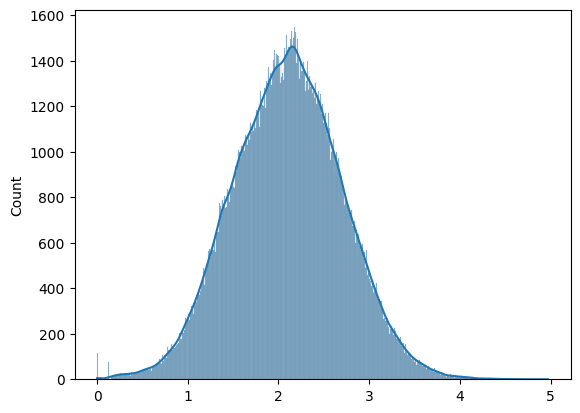

In [886]:
sns.histplot(ans_factor.select_dtypes(include=[int, float]).values.flatten(), bins=1000, kde=True)

## 1212异常预收款
$$\frac{当前季度预收款项-去年同期预收款项x正常增长乘数}{当前季度末总资产} $$
其中  
$$正常增长乘数=\frac{最新同季度销售商品、提供劳务收到的现金 }{去年同季度销售商品、提供劳务收到的现金} $$ 
说明  
异常预收款增长通常是有利信号。一方面，预收账款的异常增长可能预示着公司在供应链中的话语权上升，另一方面，预收账款的异常增长可能是管理层向下盈余操纵的手段，公司延迟将销售收入确认到利润表，转而将其放在预收款作为下-期的盈余储备。  

In [1067]:
#预售款项,总资产
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREBALANCESHEET"])
All_data = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREBALANCESHEET'][['m_anntime','m_timetag','advance_peceipts','tot_assets']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','advance_peceipts','tot_assets']]
    temp = temp[temp.m_timetag>='20180101']
    All_data = All_data.append(temp)
    #All_data = All_data.dropna()#去除了空值的股票
#All_data

In [1069]:
#销售商品、提供劳务收到的现金
financial_data = xtdata.get_financial_data(hs300_list,["ASHARECASHFLOW"])
All_data1 = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHARECASHFLOW'][['m_anntime','m_timetag','goods_sale_and_service_render_cash']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','goods_sale_and_service_render_cash']]
    temp = temp[temp.m_timetag>='20180101']
    All_data1 = All_data1.append(temp)
    #All_data1 = All_data1.dropna()#去除了空值的股票
#diff
All_data1['Year'] = All_data1['m_timetag'].apply(lambda x:x[:4])
All_data1 = All_data1.groupby('ts_code').apply(lambda x:cal_factor_dif(x,'goods_sale_and_service_render_cash'))
All_data1

,ts_code,m_anntime,m_timetag,goods_sale_and_service_render_cash,Year,goods_sale_and_service_render_cash_diff
70,000001.SZ,20180420,20180331,NaN,2018,NaN
71,000001.SZ,20180816,20180630,NaN,2018,NaN
...,...,...,...,...,...,...
21,688981.SH,20240329,20231231,5.163396e+10,2023,1.274140e+10
22,688981.SH,20240510,20240331,1.234280e+10,2024,1.234280e+10


In [1070]:
#正常增长乘数
All_data1['Normal_growth_multiplier'] = All_data1['goods_sale_and_service_render_cash_diff']/All_data1['goods_sale_and_service_render_cash_diff'].shift(4)

In [1071]:
#连接
merged_df = pd.merge(All_data,All_data1, how='inner', left_on=['ts_code','m_anntime','m_timetag'], right_on=['ts_code','m_anntime','m_timetag'])
#异常预收款
merged_df['Abnormal_advance_payment'] = (merged_df['advance_peceipts']-merged_df['advance_peceipts'].shift(4)*merged_df['Normal_growth_multiplier'])/merged_df['tot_assets']

In [1072]:
merged_df[merged_df.ts_code == '000002.SZ']

,ts_code,m_anntime,m_timetag,advance_peceipts,tot_assets,goods_sale_and_service_render_cash,Year,goods_sale_and_service_render_cash_diff,Normal_growth_multiplier,Abnormal_advance_payment
24,000002.SZ,20180426,20180331,4.793597e+11,1.224265e+12,8.070645e+10,2018,8.070645e+10,NaN,NaN
25,000002.SZ,20180821,20180630,5.142852e+11,1.345152e+12,1.805594e+11,2018,9.985293e+10,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
42,000002.SZ,20240329,20231231,3.086383e+11,1.504850e+12,2.966491e+11,2023,7.674219e+10,0.892348,-0.113044
43,000002.SZ,20240430,20240331,2.984950e+11,1.463869e+12,4.778775e+10,2024,4.778775e+10,0.566822,0.015294


In [1073]:
merged_df#000001.SZ没数据

,ts_code,m_anntime,m_timetag,advance_peceipts,tot_assets,goods_sale_and_service_render_cash,Year,goods_sale_and_service_render_cash_diff,Normal_growth_multiplier,Abnormal_advance_payment
0,000001.SZ,20180420,20180331,NaN,3.338572e+12,NaN,2018,NaN,NaN,NaN
1,000001.SZ,20180816,20180630,NaN,3.367399e+12,NaN,2018,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6664,688981.SH,20240329,20231231,1.468067e+10,3.384632e+11,5.163396e+10,2023,1.274140e+10,0.835479,0.009067
6665,688981.SH,20240510,20240331,1.359676e+10,3.417577e+11,1.234280e+10,2024,1.234280e+10,0.924628,0.000564


<Axes: xlabel='Abnormal_advance_payment', ylabel='Count'>

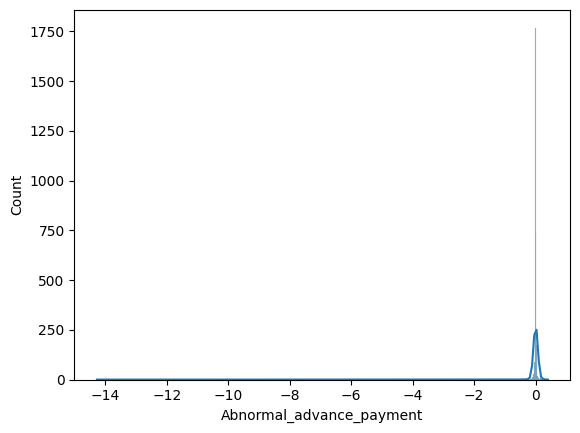

In [1074]:
sns.histplot(merged_df['Abnormal_advance_payment'], bins=1000, kde=True)

<Axes: xlabel='Abnormal_advance_payment', ylabel='Count'>

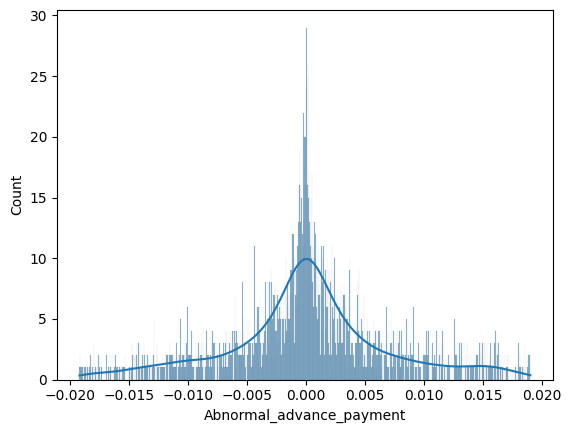

In [1075]:
#数据处理
# Calculate the first (Q1) and third (Q3) quartiles, and the interquartile range (IQR)
Q1 = merged_df['Abnormal_advance_payment'].quantile(0.25)
Q3 = merged_df['Abnormal_advance_payment'].quantile(0.75)
IQR = Q3 - Q1
# Define the outlier cutoff values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter out the outliers
filtered_df = merged_df[(merged_df['Abnormal_advance_payment'] >= lower_bound) & (merged_df['Abnormal_advance_payment'] <= upper_bound)]
sns.histplot(filtered_df['Abnormal_advance_payment'], bins=1000, kde=True)

## 1209综合债务发行-年度
$$最近报告期总负债最近1年的总负债对数增长率=In(\frac{最近报告期总负债}{上年同期总负债})$$
衡量债务发行的年度变动情况;作者发现，过去一段时间的公司债务发行对数增长率与股票未来收益负相关，存在综合债务发行效应;A股中测试发现，统计区间长达 5 年时，因子与未来收益存在负相关关系;统计区间为年度或季度时，存在正相关关系。  
(报告期去年同期认为是同期m_timetag，因为报告期浮动)

In [895]:
#总负债
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREBALANCESHEET"])
All_data = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREBALANCESHEET'][['m_anntime','m_timetag','tot_liab']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','tot_liab']]
    temp = temp[temp.m_timetag>='20180101']
    All_data = All_data.append(temp)
    #All_data = All_data.dropna()#去除了空值的股票
#All_data

In [896]:
#去年
All_data_last = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREBALANCESHEET'][['m_anntime','m_timetag','tot_liab']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','tot_liab']]
    temp = temp[temp.m_timetag>='20180101']
    All_data_last = All_data_last.append(temp)
    #All_data_last = All_data_last.dropna()#去除了空值的股票
All_data_last
#处理数据
All_data_last['m_timetag'] = pd.to_datetime(All_data_last['m_timetag'])
All_data_last['m_timetag'] = All_data_last['m_timetag'] - pd.DateOffset(years=1)
All_data_last['tot_liab'] = All_data_last.groupby('ts_code')['tot_liab'].shift(4)
# 合并当前年份和去年的数据
merged_data = pd.merge(     #内连接
    All_data,
    All_data_last,
    on=['ts_code','m_anntime'],
    suffixes=('', '_last_year')
)

# 计算存货增长率
merged_data['Logarithmic_growth_rate_of_total_liabilities'] = (
    np.log((merged_data['tot_liab']) /(merged_data['tot_liab_last_year']))
)
#merged_data = merged_data.dropna()

#取近期的单季度数据
merged_data = merged_data.drop_duplicates(subset=['ts_code', 'm_timetag'])
#merged_data = merged_data.groupby('ts_code').apply(lambda x: x.tail(1))
ans_factor = merged_data

In [897]:
ans_factor

,ts_code,m_anntime,m_timetag,tot_liab,m_timetag_last_year,tot_liab_last_year,Logarithmic_growth_rate_of_total_liabilities
0,000001.SZ,20180420,20180331,3.115181e+12,2017-03-31,NaN,NaN
1,000001.SZ,20180816,20180630,3.139258e+12,2017-06-30,NaN,NaN
...,...,...,...,...,...,...,...
8702,688981.SH,20240329,20231231,1.199930e+11,2022-12-31,1.033990e+11,0.148838
8703,688981.SH,20240510,20240331,1.230401e+11,2023-03-31,1.062983e+11,0.146261


<Axes: xlabel='Logarithmic_growth_rate_of_total_liabilities', ylabel='Count'>

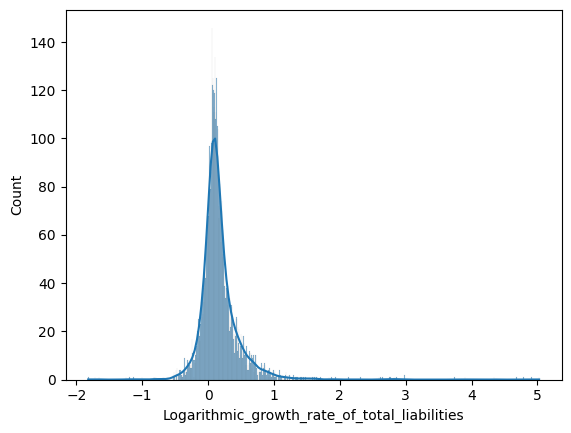

In [898]:
sns.histplot(ans_factor['Logarithmic_growth_rate_of_total_liabilities'], bins=1000, kde=True)

## 1205标准化的未预期盈余
$$\frac{最近1个季度盈余预差}{std(最近8个季度盈余预差)}$$
其中  
盈余预差=当前第t季度的每股收益-第(t-4)季度的每股收益  
说明  
盈余公告后价格漂移效应 PEAD 的衡量指标，当实际盈利高于预期盈利时，在盈余公告发布后 3-6个月内能给股价带来正面效应;反之亦然。 

In [1048]:
#每股收益（基本）
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREINCOME"])
All_data = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREINCOME'][['m_anntime','m_timetag','s_fa_eps_basic']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','s_fa_eps_basic']]
    temp = temp[temp.m_timetag>='20180101']
    All_data = All_data.append(temp)
    #All_data = All_data.dropna()#去除了空值的股票
All_data['Year'] = All_data['m_timetag'].apply(lambda x:x[:4])
All_data = All_data.groupby('ts_code').apply(lambda x:cal_factor_dif(x,'s_fa_eps_basic'))

In [1049]:
All_data

,ts_code,m_anntime,m_timetag,s_fa_eps_basic,Year,s_fa_eps_basic_diff
84,000001.SZ,20180420,20180331,0.33,2018,0.33
85,000001.SZ,20180816,20180630,0.73,2018,0.40
...,...,...,...,...,...,...
21,688981.SH,20240329,20231231,0.61,2023,0.15
22,688981.SH,20240510,20240331,0.06,2024,0.06


In [1050]:
#盈余预差
All_data['Earnings_forecast'] = All_data.groupby('ts_code')['s_fa_eps_basic_diff'].transform(lambda x: x - x.shift(4))

In [1051]:
#factor
All_data['Standardized_unexpected_earnings'] = All_data['Earnings_forecast']/All_data['Earnings_forecast'].rolling(8).std()
All_data = All_data.dropna()

In [1052]:
All_data[All_data.ts_code == '000001.SZ']

,ts_code,m_anntime,m_timetag,s_fa_eps_basic,Year,s_fa_eps_basic_diff,Earnings_forecast,Standardized_unexpected_earnings
95,000001.SZ,20210202,20201231,1.40,2020,0.29,0.07,0.745673
96,000001.SZ,20210421,20210331,0.42,2021,0.42,0.02,0.216839
...,...,...,...,...,...,...,...,...
107,000001.SZ,20240315,20231231,2.25,2023,0.31,-0.11,-1.286195
108,000001.SZ,20240420,20240331,0.66,2024,0.66,0.01,0.122710


In [1053]:
All_data

,ts_code,m_anntime,m_timetag,s_fa_eps_basic,Year,s_fa_eps_basic_diff,Earnings_forecast,Standardized_unexpected_earnings
95,000001.SZ,20210202,20201231,1.40,2020,0.29,0.07,0.745673
96,000001.SZ,20210421,20210331,0.42,2021,0.42,0.02,0.216839
...,...,...,...,...,...,...,...,...
21,688981.SH,20240329,20231231,0.61,2023,0.15,-0.19,-1.017281
22,688981.SH,20240510,20240331,0.06,2024,0.06,-0.14,-1.050188


<Axes: xlabel='Standardized_unexpected_earnings', ylabel='Count'>

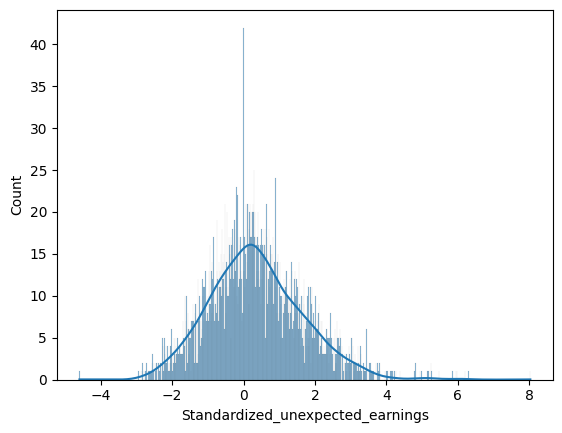

In [1054]:
#去0
All_data['Standardized_unexpected_earnings'].replace(0.0, np.nan, inplace=True)
sns.histplot(All_data['Standardized_unexpected_earnings'], bins=1000, kde=True)

## 1203单季度净利润同比增长率
$$\frac{最近单季度净利润-上年同期值}{abs(上年同期值)}$$
① 成长因子是基于股票过去一段时间的各项估值或盈利指标计算得到的增长量或增长率指标，用于衡量公司各个维度的成长性  
② 计算成长因子时，最常用的统计维度有:环比增长率(或环比增量)、同比增长率(或同比增量)，计算用的基础财务数据也有“最近12个月TTM”和“单季度”2类，经测试发现:“单季度同比”和“TTM环比”这2个维度下计算得到的因子表现通常相对更优;  
③ 至于增长率和增量，表现相差不大，增长率更具可比性，增量更不容易受基础指标取值异常的影响。  

In [1059]:
##净利润
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREINCOME"])
All_data = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREINCOME'][['m_anntime','m_timetag','net_profit_incl_min_int_inc']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','net_profit_incl_min_int_inc']]
    temp = temp[temp.m_timetag>='20180101']
    All_data = All_data.append(temp)
    #All_data = All_data.dropna()#去除了空值的股票
All_data['Year'] = All_data['m_timetag'].apply(lambda x:x[:4])
All_data = All_data.groupby('ts_code').apply(lambda x:cal_factor_dif(x,'net_profit_incl_min_int_inc'))
All_data

,ts_code,m_anntime,m_timetag,net_profit_incl_min_int_inc,Year,net_profit_incl_min_int_inc_diff
84,000001.SZ,20180420,20180331,6.595000e+09,2018,6.595000e+09
85,000001.SZ,20180816,20180630,1.337200e+10,2018,6.777000e+09
...,...,...,...,...,...,...
21,688981.SH,20240329,20231231,4.822814e+09,2023,1.148030e+09
22,688981.SH,20240510,20240331,5.089590e+08,2024,5.089590e+08


In [1060]:
#去年
All_data['Quarterly_net_profit_year-on-year_growth_rate'] = All_data.groupby('ts_code')['net_profit_incl_min_int_inc_diff'].apply(lambda x: (x - x.shift(4)) / abs(x.shift(4)))

In [1062]:
ans_factor = All_data

<Axes: xlabel='Quarterly_net_profit_year-on-year_growth_rate', ylabel='Count'>

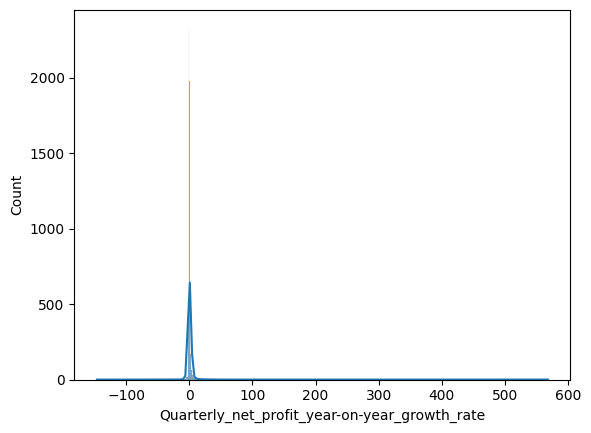

In [1063]:
ans_factor['Quarterly_net_profit_year-on-year_growth_rate'].replace(0.0, np.nan, inplace=True)
sns.histplot(ans_factor['Quarterly_net_profit_year-on-year_growth_rate'], bins=1000, kde=True)

<Axes: xlabel='Quarterly_net_profit_year-on-year_growth_rate', ylabel='Count'>

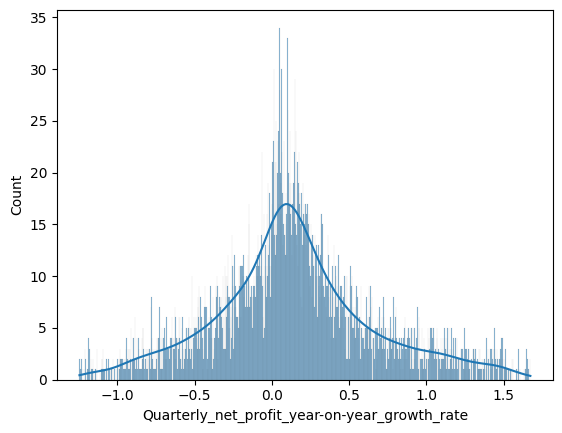

In [1064]:
#数据处理
# Calculate the first (Q1) and third (Q3) quartiles, and the interquartile range (IQR)
Q1 = ans_factor['Quarterly_net_profit_year-on-year_growth_rate'].quantile(0.25)
Q3 = ans_factor['Quarterly_net_profit_year-on-year_growth_rate'].quantile(0.75)
IQR = Q3 - Q1
# Define the outlier cutoff values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter out the outliers
filtered_df = ans_factor[(ans_factor['Quarterly_net_profit_year-on-year_growth_rate'] >= lower_bound) & (ans_factor['Quarterly_net_profit_year-on-year_growth_rate'] <= upper_bound)]
sns.histplot(filtered_df['Quarterly_net_profit_year-on-year_growth_rate'], bins=1000, kde=True)

## 1126异常毛利润
$$\frac{当前季度毛利润-去年同期毛利润x正常增长乘数}{当前季度末总资产} $$
其中  
$$正常增长乘数=\frac{最新同季度销售商品、提供劳务收到的现金 }{去年同季度销售商品、提供劳务收到的现金} $$ 
说明  
异常毛利润增长通常是有利信号。毛利润增长大于销售增长，说明毛利率在提升，这可能是由于公司产品的市场竞争力提高了，也可能是由于公司成本控制的改进。

In [923]:
#毛利润
financial_data = xtdata.get_financial_data(hs300_list,["PERSHAREINDEX"])
All_data = pd.DataFrame()
#for asset in financial_data.keys():
    #temp = financial_data[asset]['PERSHAREINDEX'][['m_anntime','m_timetag','inc_gross_profit']]
    #temp['ts_code'] = asset
    #temp = temp[['ts_code','m_anntime','m_timetag','inc_gross_profit']]
    #temp = temp[temp.m_timetag>='20180101']
    #All_data = All_data.append(temp)
    #All_data = All_data.dropna()#去除了空值的股票
#All_data

#### 由于毛利润没有在表上（迅投显示在表上实际没有），所以没实现但逻辑类似于：1212异常预收款项

In [396]:
#销售商品、提供劳务收到的现金
financial_data = xtdata.get_financial_data(hs300_list,["ASHARECASHFLOW"])
All_data1 = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHARECASHFLOW'][['m_anntime','m_timetag','goods_sale_and_service_render_cash']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','goods_sale_and_service_render_cash']]
    temp = temp[temp.m_timetag>='20180101']
    All_data1 = All_data1.append(temp)
    #All_data1 = All_data1.dropna()#去除了空值的股票
#All_data1

In [397]:
#正常增长乘数
All_data1['Normal_growth_multiplier'] = All_data1['goods_sale_and_service_render_cash']/All_data1['goods_sale_and_service_render_cash'].shift(4)

## 1118成交额波动
$$std(最近K个月日度成交额序列)$$
衡量了过去一段时间股票成交额变化的稳定程度，取值高，说明成交额波动大，股原的交易流动性风险较大。  

In [924]:
k = 3#定义最近k个月
#成交额
stdata = xtdata.get_market_data_ex(
    field_list=['amount'], stock_list=hs300_list, period='1d',
    start_time='20180101', end_time='', count=-1,
    dividend_type='front', fill_data=True
)
stocks = list(stdata.keys())
dates = list(stdata[stocks[0]].index)
data_array = np.zeros((len(dates), len(stocks)))
for i, stock in enumerate(stocks):
    data_array[:, i] = stdata[stock]['amount'].values
df_st = pd.DataFrame(data_array, index=[str(date) for date in dates], columns=stocks)
#std
df_st_std = df_st.rolling(21*k).std()
#factor
ans_factor = df_st_std

In [925]:
ans_factor

,000001.SZ,000002.SZ,000063.SZ,000100.SZ,000157.SZ,000166.SZ,000301.SZ,000333.SZ,000338.SZ,000408.SZ,...,688126.SH,688187.SH,688223.SH,688256.SH,688271.SH,688303.SH,688363.SH,688396.SH,688599.SH,688981.SH
20180102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20180103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20240805,5.823999e+08,1.658681e+09,7.646441e+08,3.451814e+08,1.168350e+08,8.960714e+07,2.876516e+07,5.575569e+08,4.374783e+08,1.128245e+08,...,1.022615e+08,1.048077e+08,3.733250e+08,8.163797e+08,1.828985e+08,6.809822e+07,7.493895e+07,9.573677e+07,2.503562e+08,6.331887e+08
20240806,5.823014e+08,1.664147e+09,7.688880e+08,3.178088e+08,1.180445e+08,8.938826e+07,2.820391e+07,5.564736e+08,4.329914e+08,1.132441e+08,...,1.016231e+08,1.044742e+08,3.736917e+08,8.087960e+08,1.833466e+08,7.023270e+07,7.441539e+07,9.529343e+07,2.505965e+08,6.269053e+08


<Axes: ylabel='Count'>

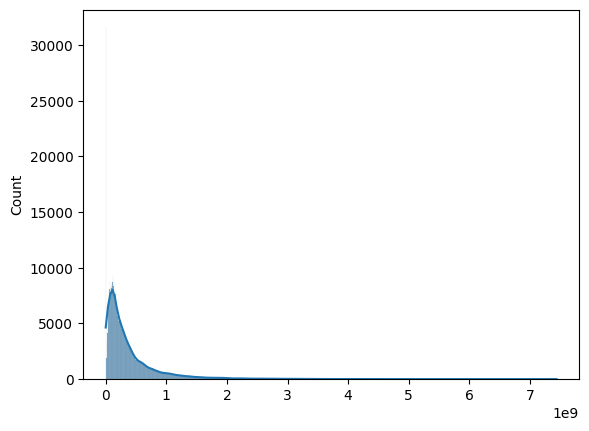

In [926]:
sns.histplot(ans_factor.select_dtypes(include=[int, float]).values.flatten(), bins=1000, kde=True)

## 1112权益乘数
$$\frac{最近报告期平均总资产}{近同期平均归属母公司股东权益合计}$$
表示总资产对净资产倍数，权益乘数反映了企业财务杠杆的大小，权益乘数越大，说明股东投入的资本在资产中所占的比重越小，财务杠杆越大。  
<span style="color:red">(周期)</span>

In [927]:
#总资产
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREBALANCESHEET"])
All_data1 = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREBALANCESHEET'][['m_anntime','m_timetag','tot_assets']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','tot_assets']]
    temp = temp[temp.m_timetag>='20180101']
    All_data1 = All_data1.append(temp)
    #All_data = All_data.dropna()#去除了空值的股票
All_data1

,ts_code,m_anntime,m_timetag,tot_assets
84,000001.SZ,20180420,20180331,3.338572e+12
85,000001.SZ,20180816,20180630,3.367399e+12
...,...,...,...,...
18,688981.SH,20240329,20231231,3.384632e+11
19,688981.SH,20240510,20240331,3.417577e+11


In [928]:
#归属于母公司股东权益合计
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREBALANCESHEET"])
All_data2 = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREBALANCESHEET'][['m_anntime','m_timetag','tot_shrhldr_eqy_excl_min_int']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','tot_shrhldr_eqy_excl_min_int']]
    temp = temp[temp.m_timetag>='20180101']
    All_data2 = All_data2.append(temp)
    #All_data = All_data.dropna()#去除了空值的股票
All_data2

,ts_code,m_anntime,m_timetag,tot_shrhldr_eqy_excl_min_int
84,000001.SZ,20180420,20180331,2.233910e+11
85,000001.SZ,20180816,20180630,2.281410e+11
...,...,...,...,...
18,688981.SH,20240329,20231231,1.424758e+11
19,688981.SH,20240510,20240331,1.426382e+11


In [929]:
#取平均(取一个报告期的？？？)
def first_last_avg(group):
    first = group.shift(1) #期初
    #last = group.iloc[-1] #期末
    #avg = (first + last) / 2
    return avg
#All_data1 = All_data1.groupby('ts_code').apply(first_last_avg)
#All_data2 = All_data2.groupby('ts_code').apply(first_last_avg)
#新的取平均
All_data1['Avg1'] = All_data1.groupby('ts_code')['tot_assets'].apply(lambda x: (x + x.shift(1)) / 2)
All_data2['Avg2'] = All_data2.groupby('ts_code')['tot_shrhldr_eqy_excl_min_int'].apply(lambda x: (x + x.shift(1)) / 2)
#因子
merged_df = pd.merge(All_data1, All_data2, how='inner', left_on=['ts_code', 'm_anntime','m_timetag'], right_on=['ts_code', 'm_anntime','m_timetag'])
merged_df['Equity_multiplier'] = merged_df['Avg1']/merged_df['Avg2']

In [930]:
merged_df

,ts_code,m_anntime,m_timetag,tot_assets,Avg1,tot_shrhldr_eqy_excl_min_int,Avg2,Equity_multiplier
0,000001.SZ,20180420,20180331,3.338572e+12,NaN,2.233910e+11,NaN,NaN
1,000001.SZ,20180816,20180630,3.367399e+12,3.352986e+12,2.281410e+11,2.257660e+11,14.851596
...,...,...,...,...,...,...,...,...
7158,688981.SH,20240329,20231231,3.384632e+11,3.370754e+11,1.424758e+11,1.427436e+11,2.361405
7159,688981.SH,20240510,20240331,3.417577e+11,3.401105e+11,1.426382e+11,1.425570e+11,2.385786


<Axes: xlabel='Equity_multiplier', ylabel='Count'>

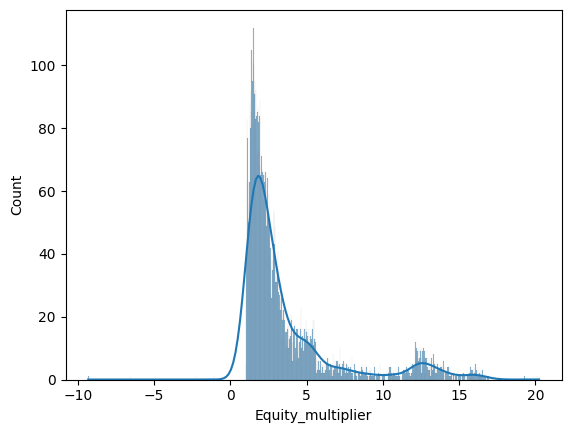

In [931]:
sns.histplot(merged_df['Equity_multiplier'], bins=1000, kde=True)

## 1108单季度经营性活动产生的现金流净额同比增长率
$$\frac{最近单季度经营性活动产生的现金流净额(TTM)-上年同期值}{abs(上年同期值)}$$
① 成长因子是基于股票过去一段时间的各项估值或盈利指标计算得到的增长量或增长率指标，用于衡量公司各个维度的成长性;  
② 计算成长因子时，最常用的统计维度有:环比增长率(或环比增量)、同比增长率(或同比增量)，计算用的基础财务数据也有“最近12个月TTM”和“单季度”2类，经测试发现:"单季度同比”和“TTM环比”这2个维度下计算得到的因子表现通常相对更优;  
③ 至于增长率和增量，表现相差不大，增长率更具可比性，增量更不容易受基础指标取值异常的影响。  

In [1077]:
#单季度经营性活动产生的现金流净额
financial_data = xtdata.get_financial_data(hs300_list,["ASHARECASHFLOW"])
All_data = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHARECASHFLOW'][['m_anntime','m_timetag','net_cash_flows_oper_act']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','net_cash_flows_oper_act']]
    temp = temp[temp.m_timetag>='20210101']
    All_data = All_data.append(temp)
    #All_data = All_data.dropna()#去除了空值的股票
All_data['Year'] = All_data['m_timetag'].apply(lambda x:x[:4])
All_data['Month'] = All_data['m_timetag'].apply(lambda x:x[4:6])
#All_data

In [1078]:
#最近的TTM
All_data = All_data.groupby('ts_code').apply(lambda x:cal_factor_ttm(x,'net_cash_flows_oper_act'))
#All_data = All_data.groupby('ts_code').apply(lambda x: x.tail(1)) 
#All_data 

In [1100]:
#去年
merged_data = All_data
merged_data['ans_factor'] = (
    (merged_data['net_cash_flows_oper_act_TTM'] - merged_data['net_cash_flows_oper_act_TTM'].shift(4)) /abs(merged_data['net_cash_flows_oper_act_TTM'].shift(4))
)

In [1101]:
merged_data

,ts_code,m_anntime,m_timetag,net_cash_flows_oper_act,Year,Month,net_cash_flows_oper_act_diff,net_cash_flows_oper_act_TTM,ans_factor
82,000001.SZ,20210421,20210331,-1.155300e+10,2021,03,-1.155300e+10,NaN,NaN
83,000001.SZ,20210820,20210630,-1.159720e+11,2021,06,-1.044190e+11,NaN,NaN
...,...,...,...,...,...,...,...,...,...
21,688981.SH,20240329,20231231,2.304776e+10,2023,12,6.700235e+09,2.304776e+10,-0.370128
22,688981.SH,20240510,20240331,3.566576e+09,2024,03,3.566576e+09,2.131419e+10,-0.322877


In [1102]:
merged_data[merged_data.ts_code == '000001.SZ']

,ts_code,m_anntime,m_timetag,net_cash_flows_oper_act,Year,Month,net_cash_flows_oper_act_diff,net_cash_flows_oper_act_TTM,ans_factor
82,000001.SZ,20210421,20210331,-1.155300e+10,2021,03,-1.155300e+10,NaN,NaN
83,000001.SZ,20210820,20210630,-1.159720e+11,2021,06,-1.044190e+11,NaN,NaN
...,...,...,...,...,...,...,...,...,...
93,000001.SZ,20240315,20231231,9.246100e+10,2023,12,-2.346900e+10,9.246100e+10,-0.312925
94,000001.SZ,20240420,20240331,-2.138200e+10,2024,03,-2.138200e+10,-3.807700e+10,-1.394168


<Axes: xlabel='ans_factor', ylabel='Count'>

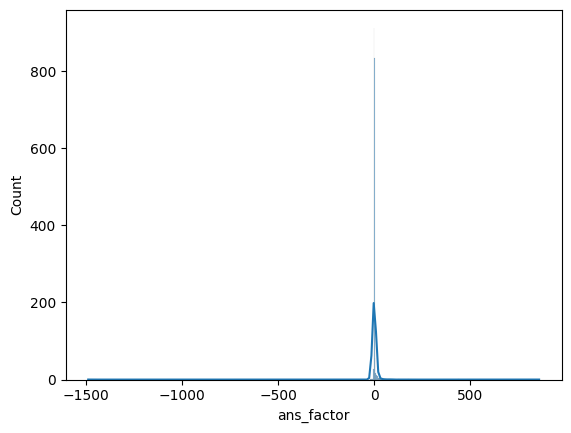

In [1103]:
sns.histplot(merged_data['ans_factor'], bins=1000, kde=True)

<Axes: xlabel='ans_factor', ylabel='Count'>

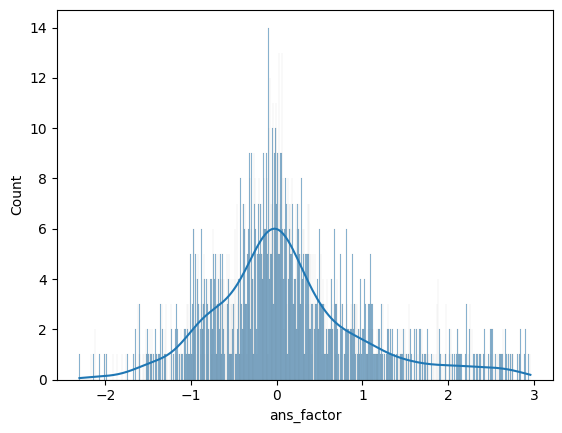

In [1104]:
#数据处理
# Calculate the first (Q1) and third (Q3) quartiles, and the interquartile range (IQR)
Q1 = merged_data['ans_factor'].quantile(0.25)
Q3 = merged_data['ans_factor'].quantile(0.75)
IQR = Q3 - Q1
# Define the outlier cutoff values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter out the outliers
filtered_df = merged_data[(merged_data['ans_factor'] >= lower_bound) & (merged_data['ans_factor'] <= upper_bound)]
sns.histplot(filtered_df['ans_factor'], bins=1000, kde=True)

## 1015市盈率增长率
$$\frac{最近报告期市盈率(TTM)}{最近12个月归属母公司净利润(TTM)同比增速}$$
当市盈率较高时，若市盈率增长率较低，说明盈利增长率较高，由于该股票的盈说明利增长表现出色，即使该股票当前有较高的市盈率，该股票相对其他股票也可能是被低估的。  

In [1106]:
#市盈率TTM
stock_price = get_price(ts_code_list = hs300_list,feature_list = ['pe_ttm'],
start_date='20180101',trade_date = '20240801',back_len = 1,target_type='stock')
stock_price = stock_price.sort_index(ascending=True)
stock_price

pe_ttm
trade_date ts_code            
2018-01-02 000001.SZ   10.2129
           000002.SZ   15.0699
...                        ...
2024-08-01 688599.SH    8.6733
           688981.SH  104.4620

[442804 rows x 1 columns]

In [1107]:
#12月归属母公司净利润
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREINCOME"])
All_data = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREINCOME'][['m_anntime','m_timetag','net_profit_excl_min_int_inc']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','net_profit_excl_min_int_inc']]
    temp = temp[temp.m_timetag>='20180101']
    All_data = All_data.append(temp)
    #All_data = All_data.dropna()#去除了空值的股票
All_data

,ts_code,m_anntime,m_timetag,net_profit_excl_min_int_inc
84,000001.SZ,20180420,20180331,6.595000e+09
85,000001.SZ,20180816,20180630,1.337200e+10
...,...,...,...,...
21,688981.SH,20240329,20231231,4.822814e+09
22,688981.SH,20240510,20240331,5.089590e+08


In [1108]:
All_data['Year'] = All_data['m_timetag'].apply(lambda x:x[:4])
All_data['Month'] = All_data['m_timetag'].apply(lambda x:x[4:6])
#最近的TTM
All_data = All_data.groupby('ts_code').apply(lambda x:cal_factor_ttm(x,'net_profit_excl_min_int_inc'))

In [1109]:
#去年
merged_data = All_data
merged_data['profit_TTM'] = (                   #12个月归属母公司同比增速TTM
    (merged_data['net_profit_excl_min_int_inc_TTM'] - merged_data['net_profit_excl_min_int_inc_TTM'].shift(4)) /(merged_data['net_profit_excl_min_int_inc_TTM'].shift(4))
)

In [1110]:
merged_data

,ts_code,m_anntime,m_timetag,net_profit_excl_min_int_inc,Year,Month,net_profit_excl_min_int_inc_diff,net_profit_excl_min_int_inc_TTM,profit_TTM
84,000001.SZ,20180420,20180331,6.595000e+09,2018,03,6.595000e+09,NaN,NaN
85,000001.SZ,20180816,20180630,1.337200e+10,2018,06,6.777000e+09,NaN,NaN
...,...,...,...,...,...,...,...,...,...
21,688981.SH,20240329,20231231,4.822814e+09,2023,12,1.148030e+09,4.822814e+09,-0.602507
22,688981.SH,20240510,20240331,5.089590e+08,2024,03,5.089590e+08,3.740449e+09,-0.656239


In [1111]:
#内连接
merged_data['m_anntime'] = pd.to_datetime(merged_data['m_anntime'])
ans_factor = pd.merge(merged_data, stock_price, how='inner', left_on=['ts_code', 'm_anntime'], right_on=['ts_code', 'trade_date'])
ans_factor['Price_to_earnings_ratio_growth_rate'] = ans_factor['pe_ttm'] / ans_factor['profit_TTM']
ans_factor

,ts_code,m_anntime,m_timetag,net_profit_excl_min_int_inc,Year,Month,net_profit_excl_min_int_inc_diff,net_profit_excl_min_int_inc_TTM,profit_TTM,pe_ttm,Price_to_earnings_ratio_growth_rate
0,000001.SZ,2018-04-20,20180331,6.595000e+09,2018,03,6.595000e+09,NaN,NaN,8.2683,NaN
1,000001.SZ,2018-08-16,20180630,1.337200e+10,2018,06,6.777000e+09,NaN,NaN,6.2797,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5384,688981.SH,2024-03-29,20231231,4.822814e+09,2023,12,1.148030e+09,4.822814e+09,-0.602507,71.9582,-119.43131
5385,688981.SH,2024-05-10,20240331,5.089590e+08,2024,03,5.089590e+08,3.740449e+09,-0.656239,91.4241,-139.31529


<Axes: xlabel='Price_to_earnings_ratio_growth_rate', ylabel='Count'>

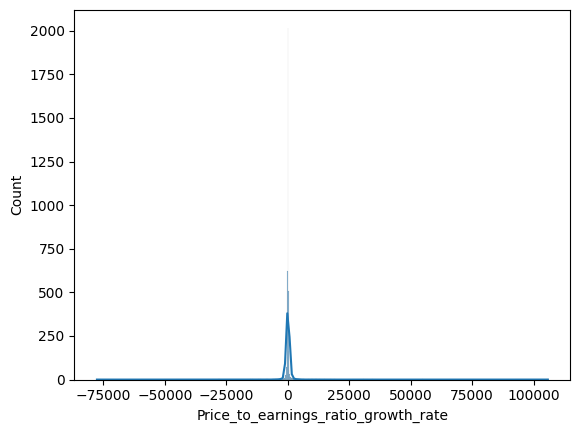

In [1112]:
sns.histplot(ans_factor['Price_to_earnings_ratio_growth_rate'], bins=1000, kde=True)

<Axes: xlabel='Price_to_earnings_ratio_growth_rate', ylabel='Count'>

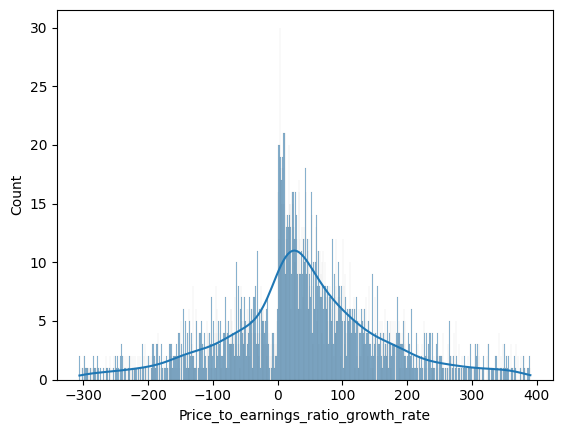

In [1113]:
#数据处理
# Calculate the first (Q1) and third (Q3) quartiles, and the interquartile range (IQR)
Q1 = ans_factor['Price_to_earnings_ratio_growth_rate'].quantile(0.25)
Q3 = ans_factor['Price_to_earnings_ratio_growth_rate'].quantile(0.75)
IQR = Q3 - Q1
# Define the outlier cutoff values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter out the outliers
filtered_df = ans_factor[(ans_factor['Price_to_earnings_ratio_growth_rate'] >= lower_bound) & (ans_factor['Price_to_earnings_ratio_growth_rate'] <= upper_bound)]
sns.histplot(filtered_df['Price_to_earnings_ratio_growth_rate'], bins=1000, kde=True)

## 0104-标准化调整的营业利润（去除空值）
$$\frac{调整的营业利润(TTM)的当期值-mean(过去T期调整的营业利润(TTM))}{std(过去T期调整的营业利润(TTM))}$$
其中  
调整的营业利润=营业利润+预收账款  
默认 T=6 个季度  
说明  
通过对常规财务数据进行标准化构造的另类成长因子，标准化后的因子与成长和盈利大类因子相关性较高，可以通过回归中心化处理剔除相关性。  

In [950]:
#营业利润
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREINCOME"])
All_data1 = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREINCOME'][['m_anntime','m_timetag','oper_profit']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','oper_profit']]
    temp = temp[temp.m_timetag>='20180101']
    All_data1 = All_data1.append(temp)
    #All_data1 = All_data1.dropna()#去除了空值的股票
#All_data1

In [951]:
#预收账款
financial_data = xtdata.get_financial_data(hs300_list,["ASHAREBALANCESHEET"])
All_data2 = pd.DataFrame()
for asset in financial_data.keys():
    temp = financial_data[asset]['ASHAREBALANCESHEET'][['m_anntime','m_timetag','advance_peceipts']]
    temp['ts_code'] = asset
    temp = temp[['ts_code','m_anntime','m_timetag','advance_peceipts']]
    temp = temp[temp.m_timetag>='20180101']
    All_data2 = All_data2.append(temp)
    #All_data2 = All_data2.dropna()#去除了空值的股票
#All_data2

In [952]:
#合并数据
merged_data = pd.merge(     #内连接
    All_data1,
    All_data2,
    on=['ts_code','m_anntime','m_timetag'],
    #suffixes=('', '_last_year')
)
#调整的营业利润
merged_data['changed_oper_profit'] = merged_data['oper_profit'] + merged_data['advance_peceipts']

In [953]:
#过去T期调整的营业利润（T=6）
T = 6
merged_data['Year'] = merged_data['m_timetag'].apply(lambda x:x[:4])
merged_data['Monthz'] = merged_data['m_timetag'].apply(lambda x:x[4:6])
merged_data = merged_data.groupby('ts_code').apply(lambda x:cal_factor_ttm(x,'changed_oper_profit'))#TTM

In [954]:
#mean
merged_data['df_mean'] = merged_data.groupby('ts_code')['changed_oper_profit_TTM'].rolling(T).mean().reset_index(level=0, drop=True)
#std
merged_data['df_std'] = merged_data.groupby('ts_code')['changed_oper_profit_TTM'].rolling(T).std().reset_index(level=0, drop=True)
#factor
merged_data['Standardized_adjusted_operating_profit'] = (merged_data['changed_oper_profit_TTM'] - merged_data['df_mean'])/merged_data['df_std']
merged_data = merged_data.dropna()#去除了空值的股票

In [286]:
merged_data[merged_data.ts_code == '000002.SZ']

,ts_code,m_anntime,m_timetag,oper_profit,advance_peceipts,changed_oper_profit,Year,Monthz,changed_oper_profit_diff,changed_oper_profit_TTM,df_mean,df_std,Standardized_adjusted_operating_profit
32,000002.SZ,20201030,20200930,4.215389e+10,6.406257e+11,6.827796e+11,2020,09,4.114552e+10,7.071331e+11,7.811798e+11,1.967439e+11,-0.376361
33,000002.SZ,20210423,20210331,4.045197e+09,6.815378e+11,6.855830e+11,2021,03,6.855830e+11,1.368363e+12,8.127011e+11,2.734650e+11,2.031930
34,000002.SZ,20210830,20210630,2.198758e+10,6.942279e+11,7.162155e+11,2021,06,3.063244e+10,7.991460e+11,8.239395e+11,2.708441e+11,-0.091542
35,000002.SZ,20211029,20210930,3.293547e+10,6.977302e+11,7.306657e+11,2021,09,1.445025e+10,7.718112e+11,8.436313e+11,2.600686e+11,-0.276158
36,000002.SZ,20220429,20220331,3.969818e+09,6.558308e+11,6.598006e+11,2022,03,6.598006e+11,1.390466e+12,9.562865e+11,3.299679e+11,1.315824
37,000002.SZ,20220831,20220630,2.423768e+10,5.876057e+11,6.118434e+11,2022,06,-4.795722e+10,6.569261e+11,9.489742e+11,3.371695e+11,-0.866176
38,000002.SZ,20221029,20220930,3.744702e+10,5.365082e+11,5.739553e+11,2022,09,-3.788817e+10,5.884055e+11,9.291863e+11,3.570965e+11,-0.954310
39,000002.SZ,20230429,20230331,4.091132e+09,4.871141e+11,4.912052e+11,2023,03,4.912052e+11,1.065160e+12,8.786526e+11,2.992928e+11,0.623162
40,000002.SZ,20230831,20230630,2.033519e+10,4.295150e+11,4.498502e+11,2023,06,-4.135504e+10,3.640048e+11,8.061291e+11,3.673864e+11,-1.203431
41,000002.SZ,20231028,20230930,2.821242e+10,4.075423e+11,4.357547e+11,2023,09,-1.409547e+10,3.978665e+11,7.438050e+11,4.042422e+11,-0.855770


In [287]:
merged_data

,ts_code,m_anntime,m_timetag,oper_profit,advance_peceipts,changed_oper_profit,Year,Monthz,changed_oper_profit_diff,changed_oper_profit_TTM,df_mean,df_std,Standardized_adjusted_operating_profit
32,000002.SZ,20201030,20200930,4.215389e+10,6.406257e+11,6.827796e+11,2020,09,4.114552e+10,7.071331e+11,7.811798e+11,1.967439e+11,-0.376361
33,000002.SZ,20210423,20210331,4.045197e+09,6.815378e+11,6.855830e+11,2021,03,6.855830e+11,1.368363e+12,8.127011e+11,2.734650e+11,2.031930
34,000002.SZ,20210830,20210630,2.198758e+10,6.942279e+11,7.162155e+11,2021,06,3.063244e+10,7.991460e+11,8.239395e+11,2.708441e+11,-0.091542
35,000002.SZ,20211029,20210930,3.293547e+10,6.977302e+11,7.306657e+11,2021,09,1.445025e+10,7.718112e+11,8.436313e+11,2.600686e+11,-0.276158
36,000002.SZ,20220429,20220331,3.969818e+09,6.558308e+11,6.598006e+11,2022,03,6.598006e+11,1.390466e+12,9.562865e+11,3.299679e+11,1.315824
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6445,688981.SH,20230512,20230331,1.896898e+09,1.449681e+10,1.639370e+10,2023,03,1.639370e+10,3.126787e+10,2.819712e+10,4.991902e+09,0.615146
6446,688981.SH,20230826,20230630,3.957629e+09,1.462765e+10,1.858528e+10,2023,06,2.191577e+09,2.531913e+10,2.936456e+10,2.325295e+09,-1.739747
6447,688981.SH,20231110,20230930,5.165463e+09,1.518809e+10,2.035355e+10,2023,09,1.768268e+09,2.265887e+10,2.828410e+10,3.604087e+09,-1.560793
6448,688981.SH,20240329,20231231,6.905885e+09,1.468067e+10,2.158655e+10,2023,12,1.233005e+09,2.158655e+10,2.688961e+10,4.366915e+09,-1.214371


<Axes: xlabel='Standardized_adjusted_operating_profit', ylabel='Count'>

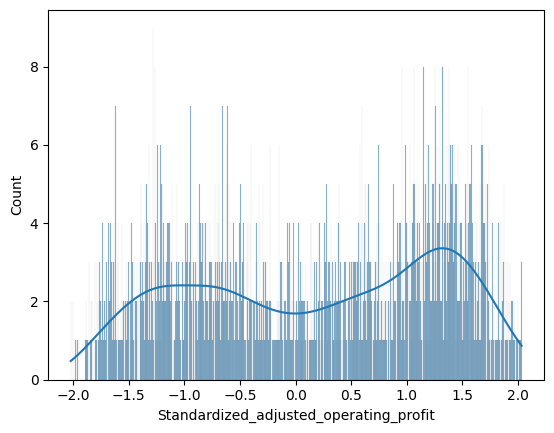

In [955]:
sns.histplot(merged_data['Standardized_adjusted_operating_profit'], bins=1000, kde=True)

## 设置

In [432]:
pd.set_option('display.max_rows',None) #None
pd.reset_option('display.max_rows')

In [963]:
pd.reset_option('display.max_rows')

In [431]:
def get_last_n_values(group, N):
    return group.tail(N)

In [310]:
xtdata.get_hkt_details('000001.SZ')

Failed to get data from server.
